## Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Benchmarking import *
import sys

In [3]:
chm = 20

In [4]:
user = "arvindsk"
# user = "wknd37"

datasets_benchmark = "/home/" + user + "/xgmix_expts/benchmark_data/val/chm{0}/{1}/{2}/generated_data/"
metrics_benchmark = "/home/" + user + "/xgmix_expts/benchmark_data/val/chm{0}/{1}/{2}/generated_data/chm{0}/"
model_root = "/home/" + user + "/xgmix_expts/benchmark_data/{1}/{2}/{3}/generated_data/chm{0}/all/models/{4}_{5}.pkl"
train_data_root = "/home/" + user + "/xgmix_expts/benchmark_data/{0}/{1}/{2}/generated_data/"

train_gens = [0,2,4,8,16,24,32,48,64,72,100]
val_gens = [2,4,8,12,16,20,30,40,50,60,70,80,90,100]

In [5]:
verbose=True

In [6]:
def run_bm(base, smooth, chm, gen_expts, models_exist=False, local_metric=None):

    for data_path in datasets_benchmark:

        # data_path must end with generated_data
        data_path = data_path + "generated_data/"

        for gen_name in gen_expts:

            bm_root = data_path + "chm{}/{}/".format(chm,gen_name)
            snp, bal, dat = np.array(bm_root.split("/"))[-7:-4]
            
            if snp == "full":
                W = 1000
            elif snp== "ukb":
                W = 30
            
            metric_path = bm_root + "benchmark_results.pkl"
            if local_metric is not None:
                metric_path = metric_path.replace("arvindsk", local_metric)

            gens = gen_expts[gen_name]

            print("-"*100)
            print("Experiment details")
            print("Dataset used: {}".format(data_path))
            print("Generations used: {}".format(gens))
            print("Metrics will come up at: {}".format(metric_path))

            metrics = bm_train(base, smooth, 
                               bm_root, data_path, 
                               gens, chm=chm,
                               W=W, 
                               load_base=True, load_smooth=True, 
                               eval=False,
                               models_exist=models_exist,
                               verbose=True)

            save_dict(metrics, metric_path)
            

In [11]:
for set_name in ["full","ukb"]:
    W = 30 if set_name == "ukb" else 1000

    for pop_name in ["latino","five","seven"]:
        
        data_path = datasets_benchmark.format(chm,set_name,pop_name)
        print("Val data from: ",data_path)
        

        for base in ["lgb", "xgb", "logreg"]:
            for smooth in ["xgb", "crf", "cnv"]:
                
                for bal in ["unbal_unbal","bal_admix"]:

                    metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(base,smooth,bal))
                    print("Metrics will show up at: ",metric_path)
                    metrics = {}

                    # load model
                    model_path = model_root.format(chm,set_name,bal,pop_name,base,smooth)
                    print("Loading model from: ",model_path)
                    
                    # load the original train and val data to get training time metrics
                    print("Getting traintime data")
                    train_data_path = train_data_root.format(set_name,bal,pop_name)
                    data, meta, _ = get_data(train_data_path, W=W, gens=train_gens, chm=chm, verbose=False)
                    (X_t1, y_t1), (X_t2, y_t2), (X_v, y_v) = data
                    
                    print("Getting validation set that was separately generated")
                    print("Val generations: ",val_gens)
                    val_paths = [data_path + "/chm{}/simulation_output/val/gen_".format(chm)    + str(gen) + "/" for gen in val_gens] 
                    X_val_files    = [p + "mat_vcf_2d.npy" for p in val_paths]
                    labels_val_files    = [p + "mat_map.npy" for p in val_paths]
                    train_val_files = [X_val_files, labels_val_files]
                    X_val_raw, labels_val_raw = [load_np_data(f) for f in train_val_files]
                    X_val, labels_window_val       = data_process(X_val_raw, labels_val_raw, W, 0)
                    val = np.array(X_val).astype("int8")
                    val_lab = np.array(labels_window_val).astype("int16")
                    
                    # glue the old train data with the new val data
                    data = ((X_t1,y_t1),(X_t2,y_t2),(val,val_lab))
                    y_snp = labels_val_raw.copy()
                    
                    # here pass on the val_gens since we only pass val set into the accuracy computing functions
                    metrics = bm_eval(model_path, data, gens=val_gens, eval_calibration=True, y_snp=y_snp, verbose=verbose)

                    save_dict(metrics,metric_path)

In [ ]:
base = ["lgb", "xgb", "logreg"]
smooth = ["xgb", "crf", "cnv"]

# here we run 3 base, 3 smooth, 2 datasets, 3 populations, 2 balance

chm = 20
gen_expts = {
    "all" : [0,2,4,8,16,24,32,48,64,72,100]
}
run_bm(base, smooth, chm, gen_expts, models_exist=False, local_metric="arvindsk")

In [50]:
expt = ["model","base","smooth","pop_name","bal","snp"]
tuples = []
for set_name in ["full","ukb"]:
    for pop_name in ["latino","five","seven"]:
        data_path = datasets_benchmark.format(chm,set_name,pop_name)
        for base in ["lgb", "xgb", "logreg"]:
            for smooth in ["xgb", "crf", "cnv"]:
                for bal in ["unbal_unbal","bal_admix"]:
                    metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(base,smooth,bal))
                    M = load_dict(metric_path)
                    skip_metrics = ["gen_performance"]
                    metric_names = [mkey for mkey in list(M.keys()) if mkey not in skip_metrics]
                    metrics = tuple([M[m] for m in metric_names])
                    tuples += [(base+"_"+smooth,base,smooth,pop_name,bal,set_name)+metrics]
                    
print(metric_names)
DF_us = pd.DataFrame(tuples, columns=expt+metric_names)
DF_us


['base_train_acc', 'base_val_acc', 'base_train_acc_bal', 'base_val_acc_bal', 'train_acc', 'val_acc', 'train_acc_bal', 'val_acc_bal', 'log_loss', 'smooth_training_time', 'smooth_inference_time', 'training_time', 'inference_time', 'model_total_size_mb', 'val_acc_snp_lvl', 'val_acc_cal', 'val_ll_cal']


,model,base,smooth,pop_name,bal,snp,base_train_acc,base_val_acc,base_train_acc_bal,base_val_acc_bal,...,val_acc_bal,log_loss,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl,val_acc_cal,val_ll_cal
0,lgb_xgb,lgb,xgb,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,96.18,0.08,187.22,0.89,291.56,1.70,59.40,97.13,97.53,0.079512
1,lgb_xgb,lgb,xgb,latino,bal_admix,full,96.90,95.48,96.67,93.64,...,95.98,0.08,185.75,0.89,301.77,1.71,59.41,97.00,97.38,0.081404
2,lgb_crf,lgb,crf,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,96.00,0.09,7.11,0.84,111.57,1.50,59.04,97.03,97.42,0.086455
3,lgb_crf,lgb,crf,latino,bal_admix,full,96.90,95.48,96.67,93.64,...,95.94,0.09,6.64,0.83,129.98,1.46,59.05,96.87,97.26,0.090306
4,lgb_cnv,lgb,cnv,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,94.57,0.10,38.58,0.01,159.77,0.64,59.03,96.50,96.85,0.096150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,logreg_xgb,logreg,xgb,seven,bal_admix,ukb,68.58,67.90,67.64,61.10,...,82.60,0.42,1903.27,4.69,3031.51,5.85,2.91,86.02,87.27,0.379566
104,logreg_crf,logreg,crf,seven,unbal_unbal,ukb,76.21,72.87,55.63,50.68,...,80.48,0.37,89.76,3.55,1171.53,3.83,2.10,87.60,88.02,0.365667
105,logreg_crf,logreg,crf,seven,bal_admix,ukb,68.58,67.90,67.64,61.10,...,81.90,0.39,42.46,3.50,1172.11,3.79,2.05,86.95,87.40,0.382104
106,logreg_cnv,logreg,cnv,seven,unbal_unbal,ukb,76.22,72.86,55.63,50.68,...,78.12,0.38,79.68,0.05,1169.70,0.33,2.06,87.19,87.43,0.377499


In [94]:
expt = ["model","base","smooth","pop_name","bal","snp"]
tuples = []
for set_name in ["ukb"]:
    for pop_name in ["seven"]:
        data_path = datasets_benchmark.format(chm,set_name,pop_name)
        for base in ["svm_random_string_kernel"]:
            for smooth in ["xgb"]:
                for bal in ["unbal_unbal"]:
                    metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(base,smooth,bal))
                    print(metric_path)
                    M = load_dict(metric_path)
                    skip_metrics = ["gen_performance"]
                    metric_names = [mkey for mkey in list(M.keys()) if mkey not in skip_metrics]
                    metrics = tuple([M[m] for m in metric_names])
                    tuples += [(base+"_"+smooth,base,smooth,pop_name,bal,set_name)+metrics]
                    
print(metric_names)
DF_only_str = pd.DataFrame(tuples, columns=expt+metric_names)
DF_str = DF_only_str.append(DF_us)
DF_str = DF_str[ (DF_str.bal == "unbal_unbal") & (DF_str.snp == "ukb") & (DF_str.pop_name == "seven")]
DF_str[["model", "val_acc"]]

/home/arvindsk/xgmix_expts/benchmark_data/val/chm20/ukb/seven/generated_data/chm20/svm_random_string_kernel_xgb_unbal_unbal.benchmark
['base_train_acc', 'base_val_acc', 'base_train_acc_bal', 'base_val_acc_bal', 'train_acc', 'val_acc', 'train_acc_bal', 'val_acc_bal', 'log_loss', 'smooth_training_time', 'smooth_inference_time', 'training_time', 'inference_time', 'model_total_size_mb', 'val_acc_snp_lvl', 'val_acc_cal', 'val_ll_cal']


,model,val_acc
0,svm_random_string_kernel_xgb,90.13
90,lgb_xgb,87.34
92,lgb_crf,87.44
94,lgb_cnv,86.86
96,xgb_xgb,86.48
98,xgb_crf,86.76
100,xgb_cnv,86.03
102,logreg_xgb,87.74
104,logreg_crf,87.81
106,logreg_cnv,87.38


In [99]:
DF_str.columns

Index(['model', 'base', 'smooth', 'pop_name', 'bal', 'snp', 'base_train_acc',
       'base_val_acc', 'base_train_acc_bal', 'base_val_acc_bal', 'train_acc',
       'val_acc', 'train_acc_bal', 'val_acc_bal', 'log_loss',
       'smooth_training_time', 'smooth_inference_time', 'training_time',
       'inference_time', 'model_total_size_mb', 'val_acc_snp_lvl',
       'val_acc_cal', 'val_ll_cal'],
      dtype='object')

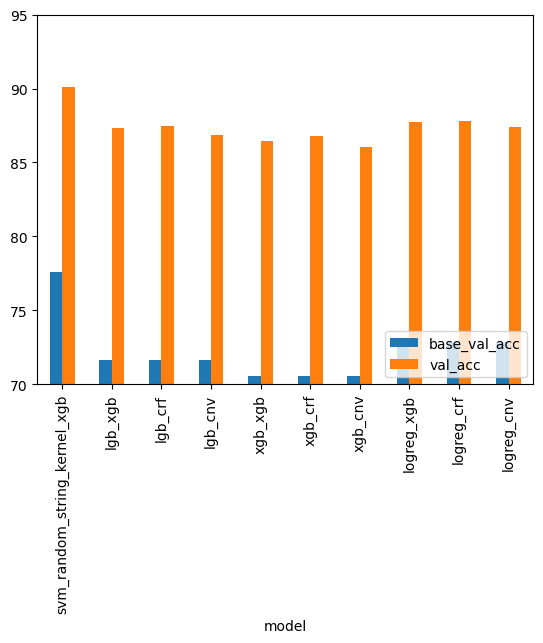

In [110]:
df_str_plot_acc = pd.DataFrame({
    "base_val_acc": list(DF_str["base_val_acc"]),
    "val_acc": list(DF_str["val_acc"])
}, index = DF_str["model"])
ax = df_str_plot_acc.plot.bar(rot=90)
plt.ylim(70,95)
plt.legend(loc="lower right")
plt.show()

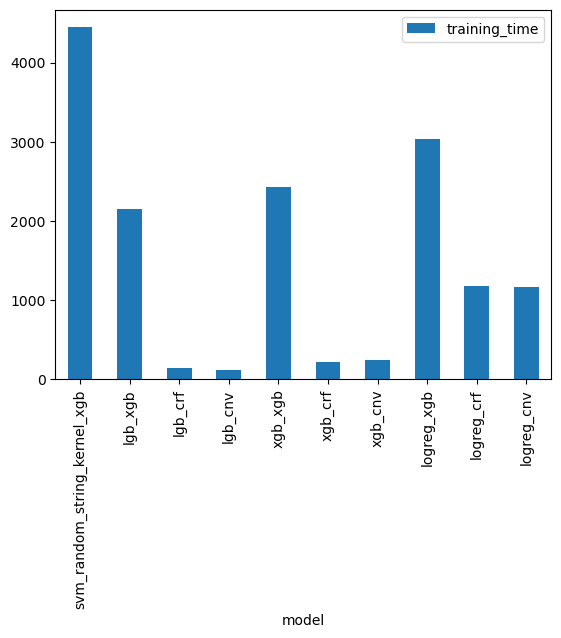

In [105]:
df_str_plot_acc = pd.DataFrame({
    "training_time": list(DF_str["training_time"])
}, index = DF_str["model"])
ax = df_str_plot_acc.plot.bar(rot=90)
plt.legend(loc="upper right")
plt.show()

In [7]:
M_rfmix = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics.pkl")
chm = "20"
M_rfmix = M_rfmix[chm]

D = {
    "pop_name": [] ,"snp": [],
    "training_time": [], "inference_time": [],
    "val_acc": [], "val_acc_snp_lvl": []
}
for m in list(M_rfmix.keys()):
    snp, pop_name = m.split("_")
    training_time = M_rfmix[m]["runtime"]
    val_acc = M_rfmix[m]["val_acc"]
    D["model"] = "rfmix"
    D["snp"].append(snp)
    D["pop_name"].append(pop_name)
    D["training_time"].append(training_time)
    D["inference_time"].append(training_time)    
    D["val_acc"].append(val_acc)
    D["val_acc_snp_lvl"].append(val_acc)
DF_rfmix = pd.DataFrame(D)
DF_rfmix

,pop_name,snp,training_time,inference_time,val_acc,val_acc_snp_lvl,model
0,latino,ukb,82.475601,82.475601,95.58,95.58,rfmix
1,five,ukb,196.271353,196.271353,90.28,90.28,rfmix
2,seven,ukb,241.045573,241.045573,84.81,84.81,rfmix
3,latino,full,1594.307887,1594.307887,95.94,95.94,rfmix
4,five,full,4260.723067,4260.723067,90.76,90.76,rfmix
5,seven,full,5518.312196,5518.312196,88.18,88.18,rfmix


In [8]:
DF = DF_us.append(DF_rfmix)
DF

,model,base,smooth,pop_name,bal,snp,base_train_acc,base_val_acc,base_train_acc_bal,base_val_acc_bal,...,val_acc_bal,log_loss,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl,val_acc_cal,val_ll_cal
0,lgb_xgb,lgb,xgb,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,96.18,0.08,187.22,0.89,291.560000,1.700000,59.40,97.13,97.53,0.079512
1,lgb_xgb,lgb,xgb,latino,bal_admix,full,96.90,95.48,96.67,93.64,...,95.98,0.08,185.75,0.89,301.770000,1.710000,59.41,97.00,97.38,0.081404
2,lgb_crf,lgb,crf,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,96.00,0.09,7.11,0.84,111.570000,1.500000,59.04,97.03,97.42,0.086455
3,lgb_crf,lgb,crf,latino,bal_admix,full,96.90,95.48,96.67,93.64,...,95.94,0.09,6.64,0.83,129.980000,1.460000,59.05,96.87,97.26,0.090306
4,lgb_cnv,lgb,cnv,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,94.57,0.10,38.58,0.01,159.770000,0.640000,59.03,96.50,96.85,0.096150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,rfmix,NaN,NaN,five,NaN,ukb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,196.271353,196.271353,NaN,90.28,NaN,NaN
2,rfmix,NaN,NaN,seven,NaN,ukb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,241.045573,241.045573,NaN,84.81,NaN,NaN
3,rfmix,NaN,NaN,latino,NaN,full,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1594.307887,1594.307887,NaN,95.94,NaN,NaN
4,rfmix,NaN,NaN,five,NaN,full,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4260.723067,4260.723067,NaN,90.76,NaN,NaN


In [9]:
DF["dataset"] = DF.apply(lambda row: row.pop_name + "-" + row.snp, axis=1)
DF

,model,base,smooth,pop_name,bal,snp,base_train_acc,base_val_acc,base_train_acc_bal,base_val_acc_bal,...,log_loss,smooth_training_time,smooth_inference_time,training_time,inference_time,model_total_size_mb,val_acc_snp_lvl,val_acc_cal,val_ll_cal,dataset
0,lgb_xgb,lgb,xgb,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,0.08,187.22,0.89,291.560000,1.700000,59.40,97.13,97.53,0.079512,latino-full
1,lgb_xgb,lgb,xgb,latino,bal_admix,full,96.90,95.48,96.67,93.64,...,0.08,185.75,0.89,301.770000,1.710000,59.41,97.00,97.38,0.081404,latino-full
2,lgb_crf,lgb,crf,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,0.09,7.11,0.84,111.570000,1.500000,59.04,97.03,97.42,0.086455,latino-full
3,lgb_crf,lgb,crf,latino,bal_admix,full,96.90,95.48,96.67,93.64,...,0.09,6.64,0.83,129.980000,1.460000,59.05,96.87,97.26,0.090306,latino-full
4,lgb_cnv,lgb,cnv,latino,unbal_unbal,full,97.67,95.54,95.87,92.56,...,0.10,38.58,0.01,159.770000,0.640000,59.03,96.50,96.85,0.096150,latino-full
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,rfmix,NaN,NaN,five,NaN,ukb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,196.271353,196.271353,NaN,90.28,NaN,NaN,five-ukb
2,rfmix,NaN,NaN,seven,NaN,ukb,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,241.045573,241.045573,NaN,84.81,NaN,NaN,seven-ukb
3,rfmix,NaN,NaN,latino,NaN,full,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1594.307887,1594.307887,NaN,95.94,NaN,NaN,latino-full
4,rfmix,NaN,NaN,five,NaN,full,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4260.723067,4260.723067,NaN,90.76,NaN,NaN,five-full


## Crushing RFMix

data: seven-full


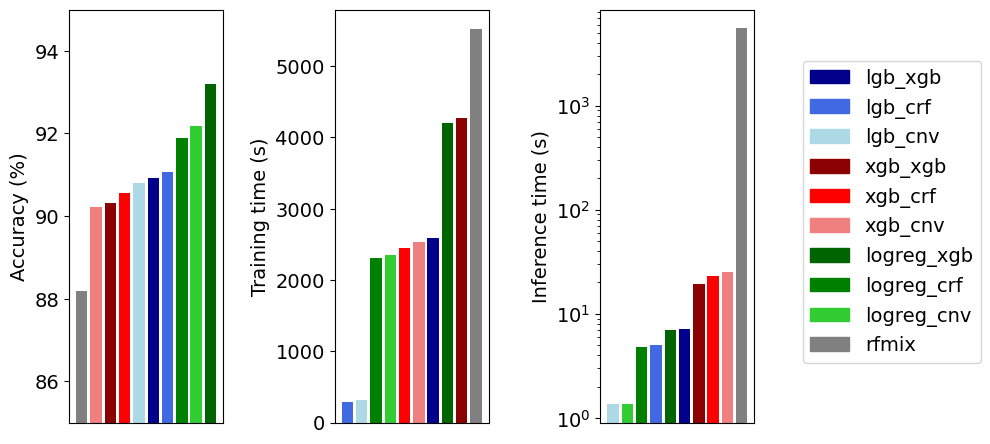

In [19]:
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.patches as mpatches

def barplot_metric_vs_data(DF, metrics, bal="bal_admix", rfmix_line=False, dataset=None, 
                           metr_labls=None, log_metrics=None, y_lims=None, fz=None, figsize=None,
                           rot="90", right_legend=True):

    DF = DF.copy()
    fig, ax = plt.subplots(1, len(metrics), figsize=figsize)
    
    colors = [s+c for c in ["blue", "red", "green"] for s in ["dark", "", "light"]]
    colors[1] = "royalblue"; colors[8] = "limegreen"; colors[5] = "lightcoral"
    colors += ["grey"]
    
    if fz is not None:
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = fz
    
    for i, metric in enumerate(metrics):
        
        log_metric = False if log_metrics is None else log_metrics[i]
        metr_labl = metr_labls[i] if metr_labls is not None else metrics[i]
    
        if dataset is None:    
            datasetorder = CategoricalDtype(
                ['latino-full', 'latino-ukb', 'five-full', 'five-ukb', 'seven-full', 'seven-ukb'],
                ordered=True
            )
            DF["dataset"] = DF["dataset"].astype(datasetorder)
            DF = DF.sort_values(by=['dataset'])
        else:
            DF = DF[DF.dataset == dataset]

        df = DF[( (DF.bal == bal) | (DF.bal.isnull()) )]

        # rfmix
        if rfmix_line:
            df_rfmix = df[df.model == "rfmix"].copy()
            df_rfmix.plot(y=metric, x="dataset", ax=ax[i], c="gray", label="rfmix")
            df = df[df.model != "rfmix"]

        if dataset is None:
            df = df[[metric, "model", "dataset"]]
            df = df.pivot(index="dataset", columns='model', values=metric)
            df.plot.bar(ax=ax[i])
        else:
            metric_model = list(zip(df[metric], df.model, colors))
            sortd = sorted(metric_model, key = lambda x:x[0])
            metr, mdl, cols = list(zip(*sortd))
            ax[i].bar(x=mdl, height=metr, color=cols)
            if log_metric:
                ax[i].set_yscale("log")

        if y_lims is not None:
            ax[i].set_ylim(y_lims[i])
        ax[i].set_ylabel(metr_labl, fontsize=fz)
        # ax[i].set_xlabel("model", fontsize=fz)
        ax[i].set_xticks([])
        for tick in ax[i].get_xticklabels():
            tick.set_rotation(rot)
            

    print("data:", dataset)
    fig.tight_layout(pad=2.0)    

    if right_legend:
        patches = []
        for i, color in enumerate(colors):
            patches.append(mpatches.Patch(color=color, label=list(df.model)[i] ))
        ax[-1].legend(handles=patches, bbox_to_anchor=(1.25, 0.9), loc='upper left')

        plt.show()
    
barplot_metric_vs_data(
    DF, dataset="seven-full",
    metrics = ["val_acc_snp_lvl", "training_time", "inference_time"],
    metr_labls = ["Accuracy (%)", "Training time (s)" , "Inference time (s)"],
    y_lims = ((85,95), None, None),
    log_metrics = (False, False, True),
    figsize = [8, 4.8],
    fz=14
)


data: seven-ukb


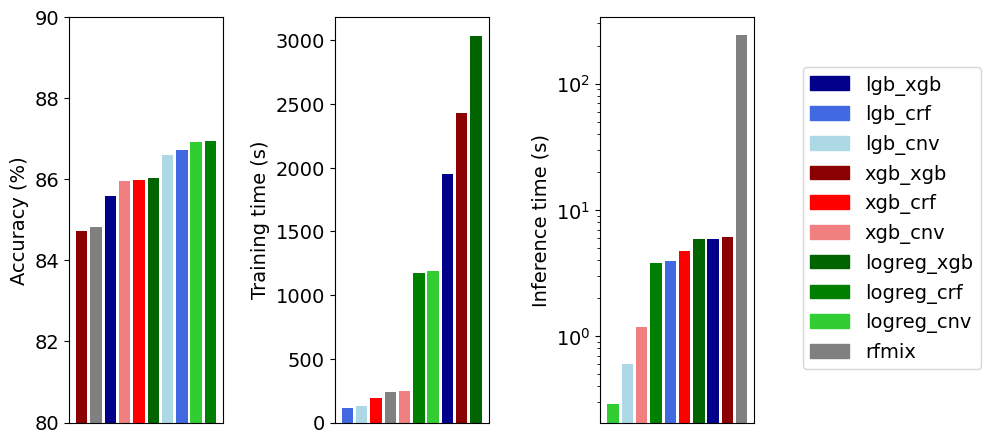

In [25]:
barplot_metric_vs_data(
    DF, dataset="seven-ukb",
    metrics = ["val_acc_snp_lvl", "training_time", "inference_time"],
    metr_labls = ["Accuracy (%)", "Training time (s)" , "Inference time (s)"],
    y_lims = ((80,90), None, None),
    log_metrics = (False, False, True),
    figsize = [8, 4.8],
    fz=14
)

## Lost cross over trait in generation wise accuracy

ancestry:seven, snps:full


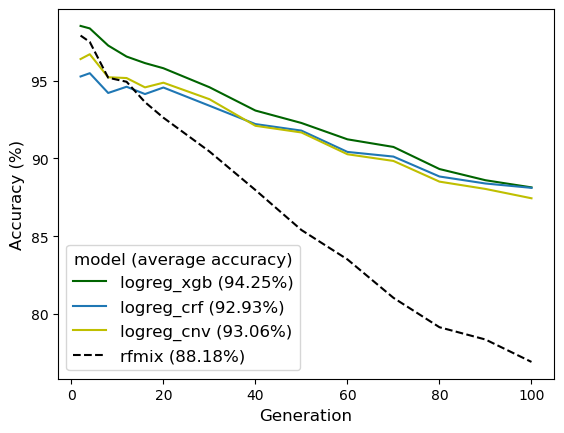

ancestry:seven, snps:ukb


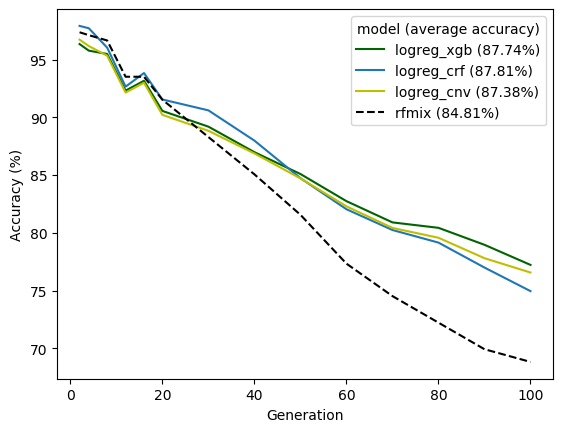

In [475]:
def plot_acc_vs_gen(chm, set_name, pop_name, bal, base, smooth, title=False, fz=None, figsize=None):

    
    mpl.rcParams.update(mpl.rcParamsDefault)
    if fz is not None:
        fig, ax = plt.subplots(figsize=figsize)
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = fz
        mpl.rcParams['legend.title_fontsize'] = fz

    
    cmap = { 0:'darkgreen', 1:'tab:blue',  2:'y', 3:'g'}
    lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }
    acc_str = lambda acc: " (" + str(acc) + "%)"
    for i, b in enumerate(base):
        for j, s in enumerate(smooth):
            metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(b,s,bal))
            M = load_dict(metric_path)
            val_acc = M["val_acc"]
            m_name = b + "_" + s
            G = M["gen_performance"]
            plt.plot(G["gens"], G["accs_snp_lvl"], linestyle=lmap[i%len(lmap)], color=cmap[j%len(cmap)],
                             label= m_name + acc_str(val_acc))

    # RFmix
    M_gen_rfmix_raw = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics_gen_wise.pkl")
    G_rfmix = M_gen_rfmix_raw[chm][set_name+"_"+pop_name]
    plt.plot(G["gens"], G_rfmix["genwise_val_acc"], linestyle="--", color="k",
                     label= "rfmix" + acc_str(G_rfmix["val_acc"]))

    data = "ancestry:" + pop_name + ", snps:" +set_name
    print(data)
    plt.legend(title="model (average accuracy)")
    plt.xlabel("Generation", fontsize=fz)
    plt.ylabel("Accuracy (%)", fontsize=fz)
    plt.show()

chm = "20"
pop_name = "seven" 
bal = "unbal_unbal"
base = ["logreg"]
smooth = ["xgb", "crf", "cnv"]

plot_acc_vs_gen(chm, "full", pop_name, bal, base, smooth, fz=12)
plot_acc_vs_gen(chm, "ukb", pop_name, bal, base, smooth)


ancestry:seven, snps:ukb


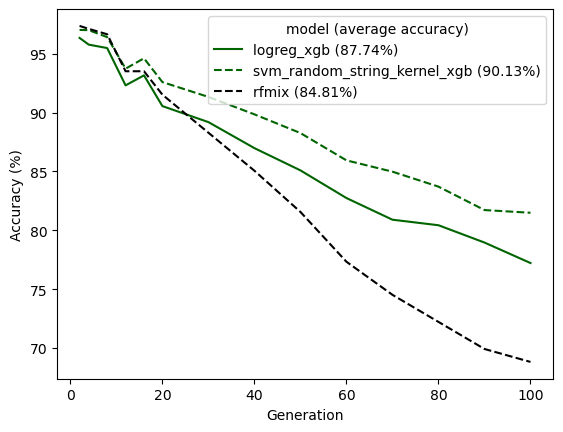

In [98]:
def plot_acc_vs_gen(chm, set_name, pop_name, bal, base, smooth, title=False, fz=None, figsize=None):

    
    mpl.rcParams.update(mpl.rcParamsDefault)
    if fz is not None:
        fig, ax = plt.subplots(figsize=figsize)
        mpl.rcParams['xtick.labelsize'] = fz 
        mpl.rcParams['ytick.labelsize'] = fz 
        mpl.rcParams['legend.fontsize'] = fz
        mpl.rcParams['legend.title_fontsize'] = fz

    
    cmap = { 0:'darkgreen', 1:'tab:blue',  2:'y', 3:'g'}
    lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }
    acc_str = lambda acc: " (" + str(acc) + "%)"
    for i, b in enumerate(base):
        for j, s in enumerate(smooth):
            metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(b,s,bal))
            M = load_dict(metric_path)
            val_acc = M["val_acc"]
            m_name = b + "_" + s
            G = M["gen_performance"]
            plt.plot(G["gens"], G["accs_snp_lvl"], linestyle=lmap[i%len(lmap)], color=cmap[j%len(cmap)],
                             label= m_name + acc_str(val_acc))

    # RFmix
    M_gen_rfmix_raw = load_dict("/home/arvindsk/xgmix_expts/benchmark_data/rfmix/metrics_gen_wise.pkl")
    G_rfmix = M_gen_rfmix_raw[chm][set_name+"_"+pop_name]
    plt.plot(G["gens"], G_rfmix["genwise_val_acc"], linestyle="--", color="k",
                     label= "rfmix" + acc_str(G_rfmix["val_acc"]))

    data = "ancestry:" + pop_name + ", snps:" +set_name
    print(data)
    plt.legend(title="model (average accuracy)")
    plt.xlabel("Generation", fontsize=fz)
    plt.ylabel("Accuracy (%)", fontsize=fz)
    plt.show()

chm = "20"
pop_name = "seven" 
bal = "unbal_unbal"
base = ["logreg", "svm_random_string_kernel"]
smooth = ["xgb"]

# plot_acc_vs_gen(chm, "full", pop_name, bal, base, smooth, fz=12)
plot_acc_vs_gen(chm, "ukb", pop_name, bal, base, smooth)


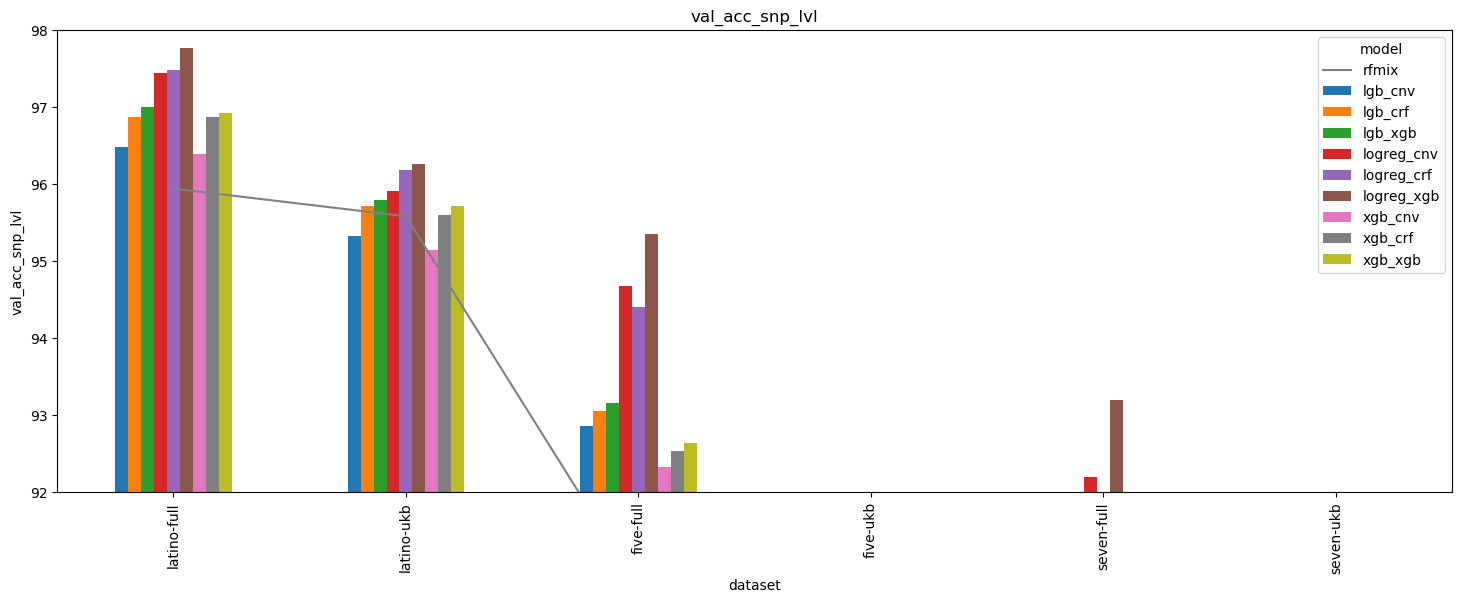

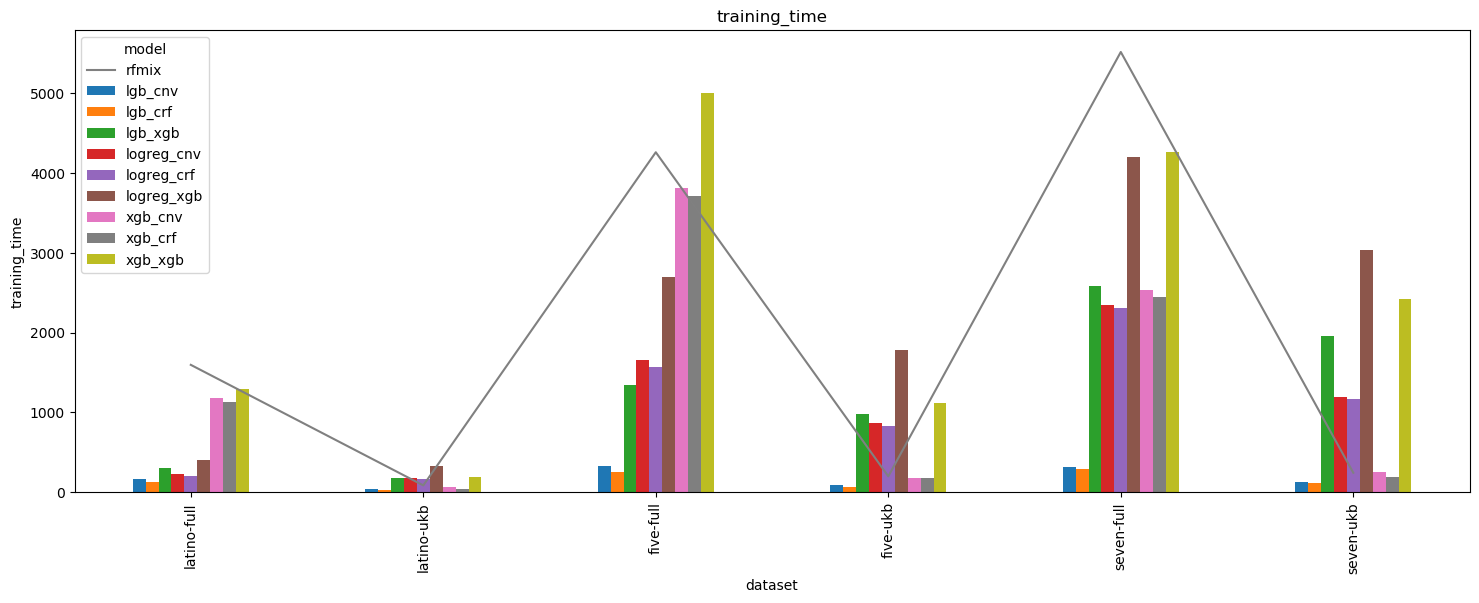

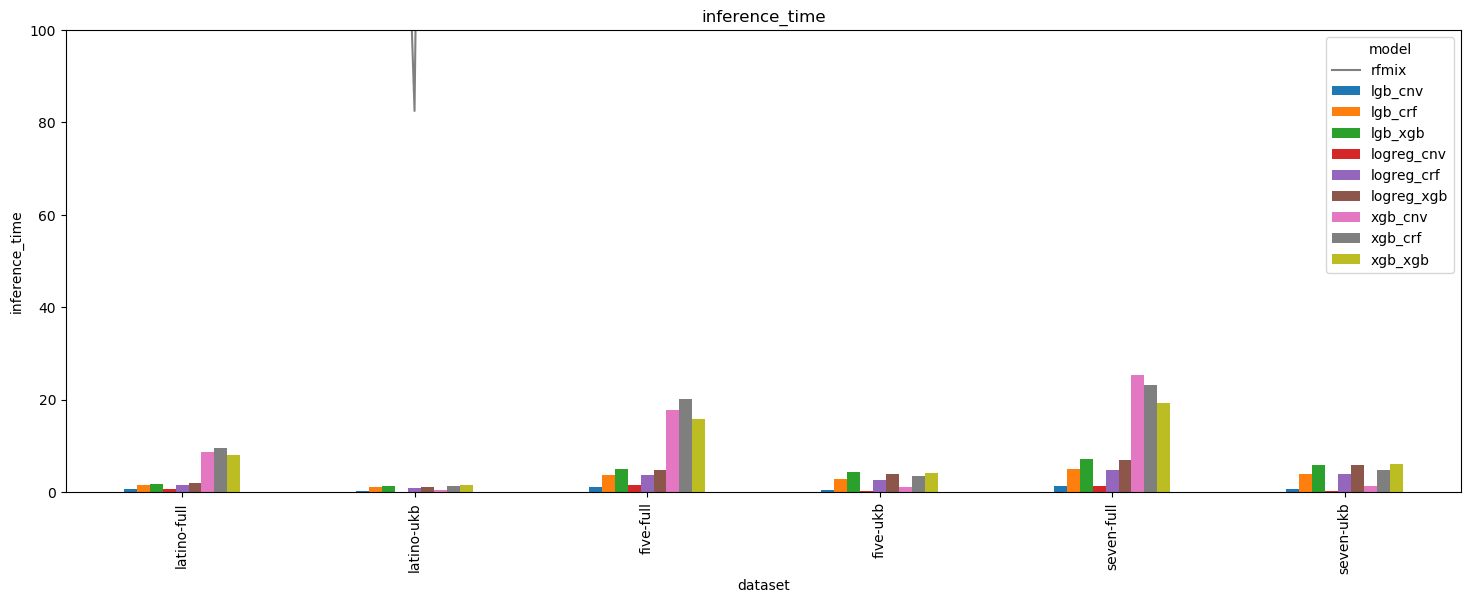

In [314]:
from pandas.api.types import CategoricalDtype

def barplot_metric_vs_data(DF, metric, bal="bal_admix", ylim=None):

    DF = DF.copy()
    fig, ax = plt.subplots(figsize=(18,6))
    
    datasetorder = CategoricalDtype(
        ['latino-full', 'latino-ukb', 'five-full', 'five-ukb', 'seven-full', 'seven-ukb'],
        ordered=True
    )
    DF["dataset"] = DF["dataset"].astype(datasetorder)
    DF = DF.sort_values(by=['dataset'])
    df = DF[( (DF.bal == bal) | (DF.bal.isnull()) )]
    
    df_rfmix = df[df.model == "rfmix"].copy()
    df = df[df.model != "rfmix"]
    df = df[[metric, "model", "dataset"]]
    df = df.pivot(index="dataset", columns='model', values=metric)

    df_rfmix.plot(y=metric, x="dataset", ax=ax, c="gray", label="rfmix")
    df.plot.bar(ax=ax)
    ax.set_ylim(ylim)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    plt.show()
    
barplot_metric_vs_data(DF, "val_acc_snp_lvl", ylim=(92,98))
barplot_metric_vs_data(DF, "training_time")
barplot_metric_vs_data(DF, "inference_time",  ylim=(0,100))


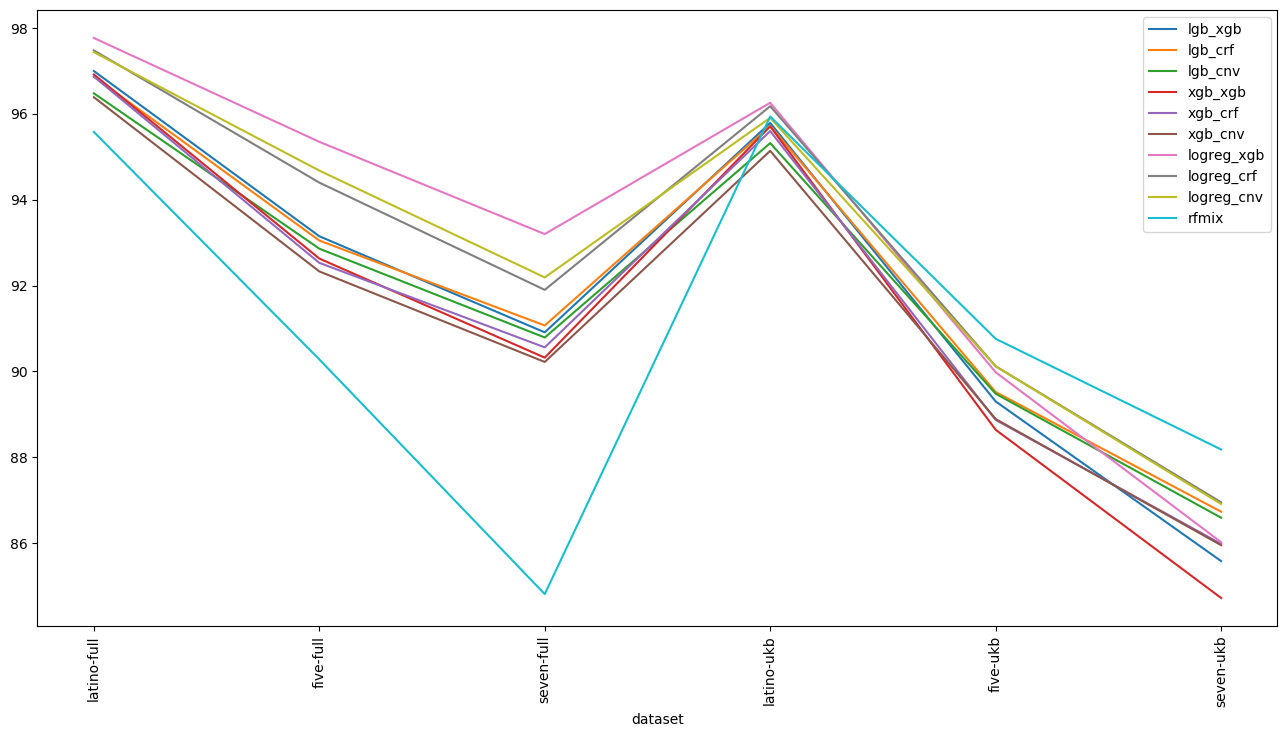

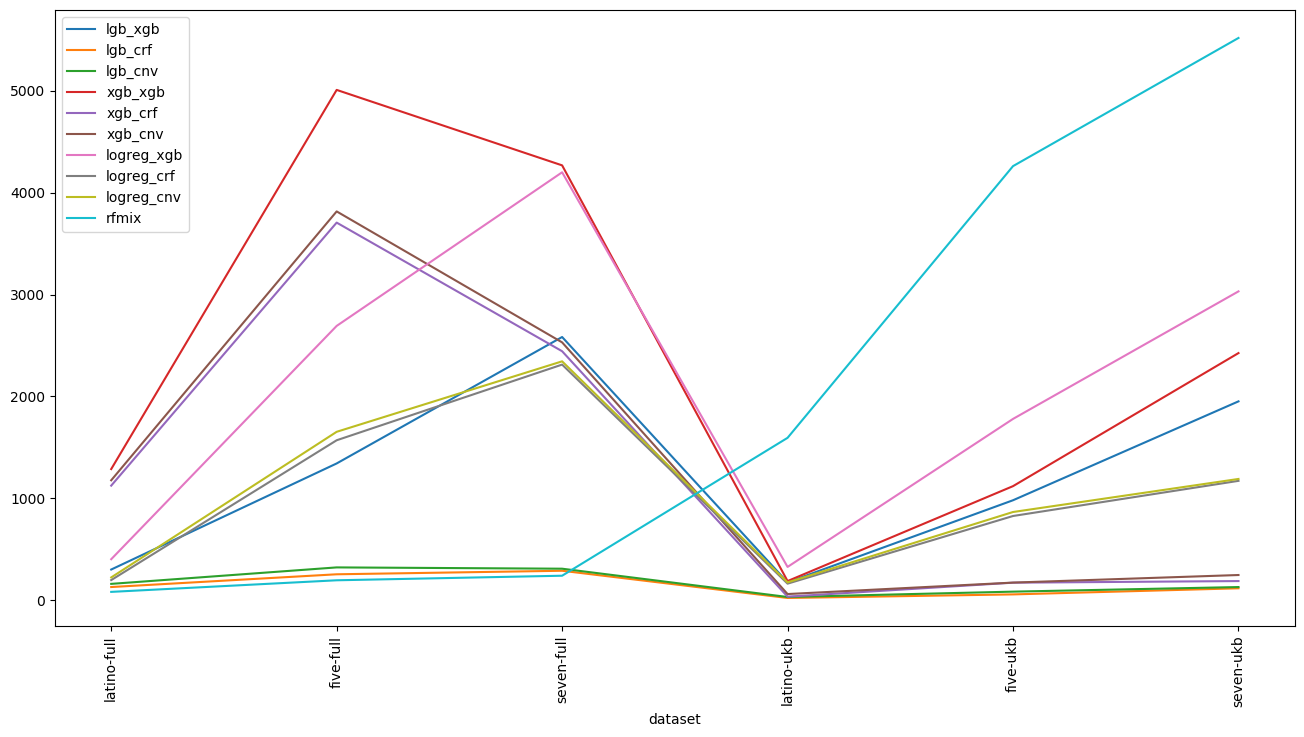

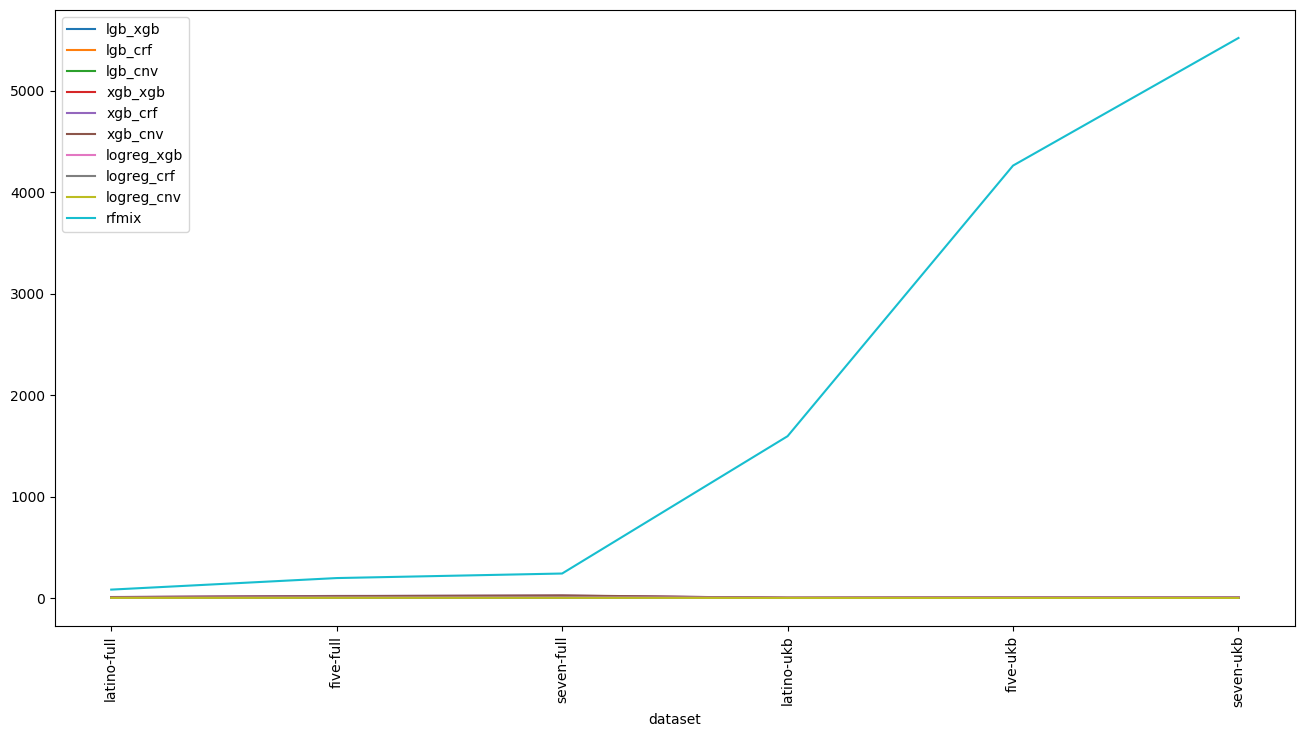

In [262]:
def plot_metric_vs_data(DF, metric, bal="bal_admix"):

    DF = DF[ (DF.bal == bal) | (DF.bal.isnull()) ].copy()
    cmap = { 0:'b', 1:'pink',  2:'g'}
    lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }
    fig, ax = plt.subplots(figsize=(18,6))
    
    datasets = DF["dataset"].unique()
    models = DF["model"].unique()
    
    for m, model in enumerate(models):
        df = DF[DF["model"] == model]
        df.plot(y=metric, x="dataset", ax=ax, figsize=(16,8), rot="90", label=model)
    ax.set_xticks(np.arange(len(datasets)))
    ax.set_xticklabels(datasets)
    plt.show()
    
plot_metric_vs_data(DF, "val_acc_snp_lvl")
plot_metric_vs_data(DF, "training_time")
plot_metric_vs_data(DF, "inference_time")


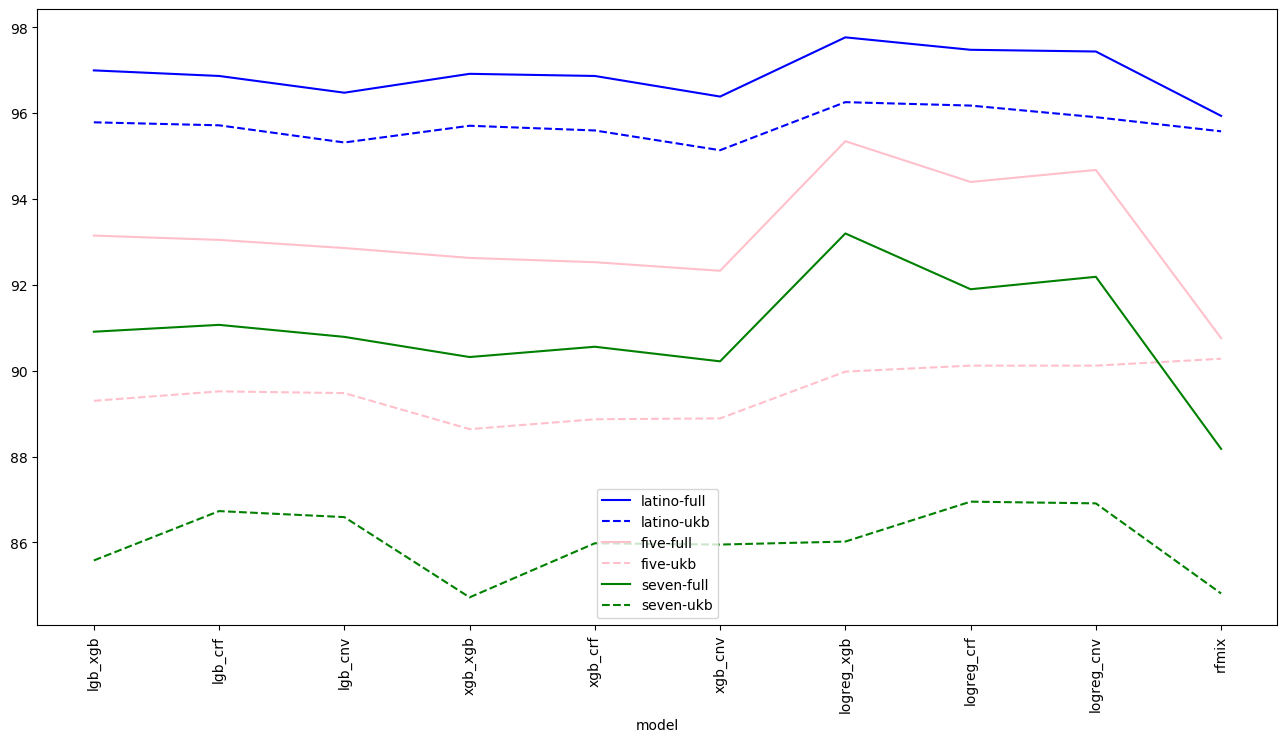

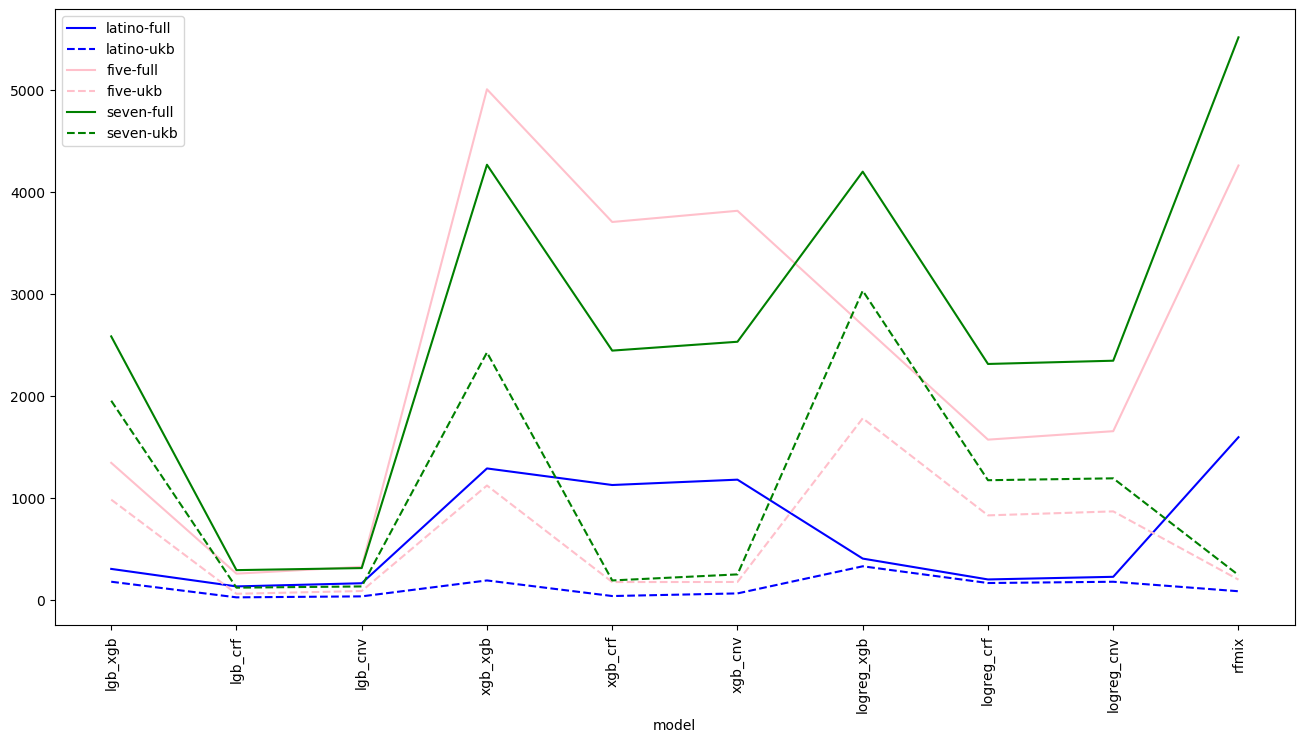

In [202]:
def plot_metric_vs_model(DF, metric, bal="bal_admix"):

    cmap = { 0:'b', 1:'pink',  2:'g'}
    lmap = { 0:'-', 1:'--', 2:':', 3:'-.' }
    x = "model"
    fig, ax = plt.subplots(figsize=(18,6))
    
    DF_bal = DF[ (DF.bal == bal) | (DF.bal.isnull()) ]
    for p, pop in enumerate(DF_bal.pop_name.unique()):
        df_p = DF_bal[DF_bal["pop_name"] == pop]
        for s, snp in enumerate(df_p.snp.unique()):
            df = df_p[df_p["snp"] == snp]
            df.plot(y=metric, x=x, ax=ax, figsize=(16,8), rot="90", 
                    color=cmap[p], linestyle=lmap[s], label=pop+"-"+snp)
    
    ax.set_xticks(np.arange(len(DF[x].unique())))
    ax.set_xticklabels(DF[x].unique())
    plt.show()
    
plot_metric_vs_model(DF, "val_acc_snp_lvl")
plot_metric_vs_model(DF, "training_time")


In [582]:
# RELIABILITY PLOTS

from Utils.Calibration import *

def plot_reliability_curve(pred_prob,y_cal,pop_order,method='Uncalibrated',bins=10, legend=True):
    
    fig, (ax1) = plt.subplots(nrows = 1, ncols=1, figsize = (8,6))
                                              
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.set_title(method + ' Reliability Plot')
        
    class_metrics = {}
    n_classes = len(pop_order)
    for i in range(n_classes):
        y_label = np.where(y_cal==i,1,0)
        est_prob = pred_prob[:,:,i]
        true_prob, pred_proba = calibration_curve(y_label.flatten(),est_prob.flatten(), n_bins = bins)
        ax1.plot(pred_proba, true_prob, label = pop_order[i])
        
        ax1.set_xlabel('Est. Prob/ mean predicted value')
        ax1.set_ylabel('True Prob/fraction_of_positives')
        
        y_test = y_label.flatten()
        y_pred =np.where(est_prob.flatten()>1/n_classes,1,0)
        
        class_metrics[pop_order[i]]={}
        class_metrics[pop_order[i]]['Precision'] = float("%1.3f" %precision_score(y_test, y_pred))
        class_metrics[pop_order[i]]['Recall'] = float("%1.3f" %recall_score(y_test, y_pred))
        class_metrics[pop_order[i]]['F1'] = float("%1.3f" %f1_score(y_test, y_pred))
        class_metrics[pop_order[i]]['AUC'] = float("%1.3f" %roc_auc_score(y_test, y_pred))

    if legend:
        ax1.legend(loc="lower right")
    fig.tight_layout()
    plt.show()
    return class_metrics

In [7]:
set_name = "full"
W = 30 if set_name == "ukb" else 1000
pop_name = "latino"
data_path = datasets_benchmark.format(chm,set_name,pop_name)
base = "logreg"
smooth = "xgb"
bal = "bal_admix"

metric_path = os.path.join(metrics_benchmark.format(chm,set_name,pop_name),"{}_{}_{}.benchmark".format(base,smooth,bal))
print("Metrics will show up at: ",metric_path)
metrics = {}

# load model
model_path = model_root.format(chm,set_name,bal,pop_name,base,smooth)
print("Loading model from: ",model_path)

# load the original train and val data to get training time metrics
print("Getting traintime data")
train_data_path = train_data_root.format(set_name,bal,pop_name)
data, meta, _ = get_data(train_data_path, W=W, gens=train_gens, chm=chm, verbose=False)
(X_t1, y_t1), (X_t2, y_t2), (X_v, y_v) = data

print("Getting validation set that was separately generated")
print("Val generations: ",val_gens)
val_paths = [data_path + "/chm{}/simulation_output/val/gen_".format(chm)    + str(gen) + "/" for gen in val_gens] 
X_val_files    = [p + "mat_vcf_2d.npy" for p in val_paths]
labels_val_files    = [p + "mat_map.npy" for p in val_paths]
train_val_files = [X_val_files, labels_val_files]
X_val_raw, labels_val_raw = [load_np_data(f) for f in train_val_files]
X_val, labels_window_val       = data_process(X_val_raw, labels_val_raw, W, 0)
val = np.array(X_val).astype("int8")
val_lab = np.array(labels_window_val).astype("int16")

# glue the old train data with the new val data
data = ((X_t1,y_t1),(X_t2,y_t2),(val,val_lab))
y_snp = labels_val_raw.copy()

# here pass on the val_gens since we only pass val set into the accuracy computing functions
# metrics = bm_eval(model_path, data, gens=val_gens, eval_calibration=True, y_snp=y_snp, verbose=verbose)


Metrics will show up at:  /home/arvindsk/xgmix_expts/benchmark_data/val/chm20/full/latino/generated_data/chm20/logreg_xgb_bal_admix.benchmark
Loading model from:  /home/arvindsk/xgmix_expts/benchmark_data/full/bal_admix/latino/generated_data/chm20/all/models/logreg_xgb.pkl
Getting traintime data
Getting validation set that was separately generated
Val generations:  [2, 4, 8, 12, 16, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [8]:
pop_order = np.genfromtxt(data_path + "/populations.txt", dtype="str")
(X_t1, y_t1), (X_t2, y_t2), (X_v, y_v) = data

In [9]:
model = load_model(model_path)

Loading model...


/home/wknd37/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Confusion Matrices

In [601]:
y_v_pred = model.predict(X_v,rtn_calibrated=False)

Confusion matrix for validation data:
[[117491    563    219     83     62    243    313]
 [   885 144655    713    829   1052   1679    511]
 [   383    810  39091    280     85   2016   2712]
 [   108    561    315  22281     29    118    164]
 [    31     95     12      8   5202     61     15]
 [   434   1945   2150    255    428  44884   1344]
 [   769    317   2290     57     45   1131  19268]]


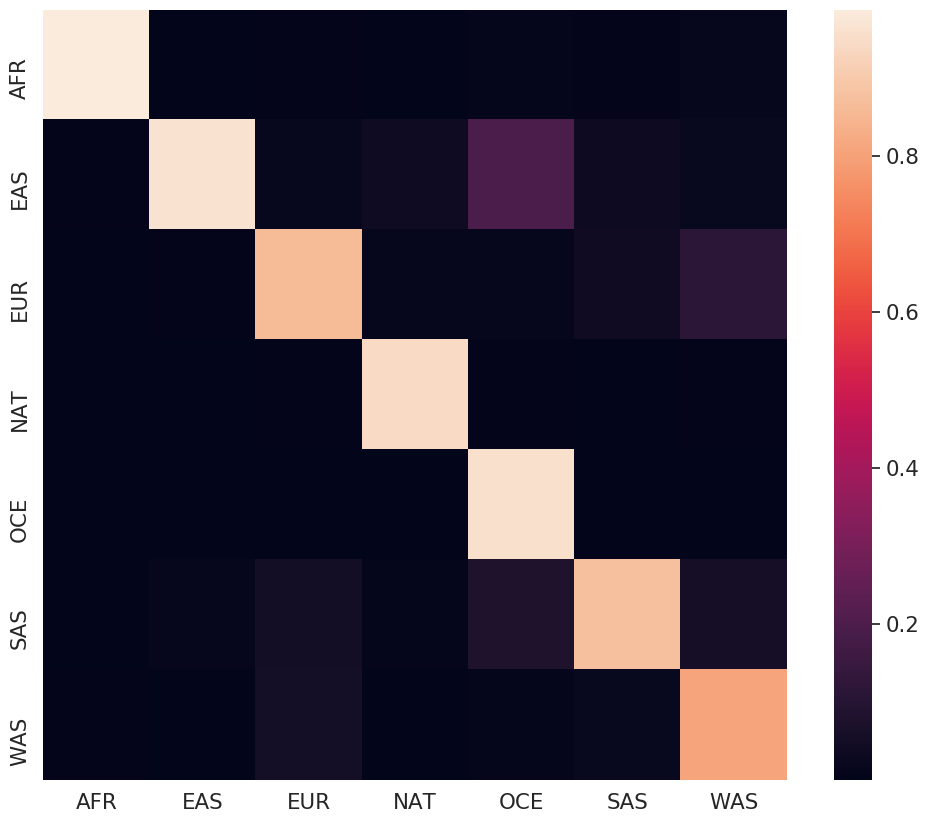

In [602]:
from Utils.visualization import *
cm = CM(y_v.reshape(-1), y_v_pred.reshape(-1), labels=pop_order)
plot_cm(cm, labels=pop_order)

In [11]:
base_proba, _ = model._get_smooth_data(X_v, flat_base=True)
smoother_proba = model.predict_proba(X_v) # pass through smoother

In [30]:
from Utils.utils import read_genetic_map
genetic_map_file = "/home/database/maps/rfmix/allchrs.b37.gmap"
gmap = read_genetic_map(genetic_map_file, "20")
chm_len_cM = list(gmap.pos_cm)[-1]
n_wind = y_v.shape[1]
x_ticks = np.arange(0,chm_len_cM,chm_len_cM/n_wind)

In [74]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from mpl_toolkits import mplot3d

def xgmix_plot_2d(base_proba, smoother_proba, y_true, pop_order, x=None, rand_ind=145, x_ticks=False,
                  theme=None, fz=20, tz=30, figsize=(12,8), xlab=None, toplabelpad=20, xlim=None):

    mpl.rcParams['xtick.labelsize'] = fz 
    mpl.rcParams['ytick.labelsize'] = fz 
    mpl.rcParams['legend.fontsize'] = fz
    
    n_wind = y_true.shape[-1]

    base_proba_i = base_proba[rand_ind]
    smoother_proba_i = smoother_proba[rand_ind]

    plt.figure(figsize=figsize)
    palette = np.array(sns.color_palette("tab10").as_hex())
    base_pos = 1.05; smot_pos = 1.10; true_pos = 1.15
    # base_pos = -.05; smot_pos = 1.05; true_pos = 1.10

    if x is None:
        x=np.range(n_wind)
        
    for i, p in enumerate(smoother_proba_i.T):
        plt.plot(x,p,alpha=0.85,label=pop_order[i]+" (smooth)",color=palette[i])
    for i, p in enumerate(base_proba_i.T):
        plt.plot(x,p,alpha=0.35, label=pop_order[i]+" (base)", color=palette[i])    
    # plt.scatter(range(max(x)), np.repeat(1.2, max(x)), color="black", alpha=0.1, marker="s") # for grid size
    plt.scatter(x, np.repeat(base_pos, n_wind), c=palette[np.argmax(base_proba_i,axis=1)], marker="s")
    plt.scatter(x, np.repeat(smot_pos, n_wind), c=palette[np.argmax(smoother_proba_i,axis=1)], marker="s")
    plt.scatter(x, np.repeat(true_pos, n_wind), c=palette[y_true[rand_ind]], marker="s")
    plt.legend(bbox_to_anchor=(1.025, 0.8), loc='upper left', borderaxespad=0.)
    plt.text(max(x)+toplabelpad, base_pos-0.02, r'Base Prediction', fontsize=fz)
    plt.text(max(x)+toplabelpad, smot_pos-0.02, r'Smooth Prediction', fontsize=fz)
    plt.text(max(x)+toplabelpad, true_pos-0.02, r'True Labels', fontsize=fz)
    
    if xlab is not None:
        plt.xlabel(xlab, fontsize=fz)
        
    numeric_ticks = np.concatenate(((0.0, 0.2, 0.4, 0.6, 0.8, 1.0),(base_pos,smot_pos,true_pos)))
    label_ticks   = np.concatenate(((0.0, 0.2, 0.4, 0.6, 0.8, 1.0),("", "", "")))
    plt.yticks(numeric_ticks, label_ticks)
    plt.ylabel("Probability", fontsize=fz)
    plt.xlim(xlim)
    plt.show()


def plot_ancestry_3d(ancestry, palette, z_pos, y_pos):
    for i, a in enumerate(ancestry):
        ax.plot([i,i+1],[y_pos,y_pos],[z_pos,z_pos],color=palette[a],linewidth=5)

def xgmix_plot_3d(base_proba, smoother_proba, y_true, pop_order, rand_ind=145, view="bottom", theme=None):

    sns.set_style(theme)

    # from matplotlib import interactive
    # interactive(True)
    # %matplotlib inline
    # %matplotlib qt

    n_wind = y_true.shape[-1]
    n_anc = len(pop_order)
    
    base_proba_i = base_proba[rand_ind]
    smoother_proba_i = smoother_proba[rand_ind]

    plt.figure(figsize=(12,8))
    palette = np.array(sns.color_palette("tab10").as_hex())
    base_pos = 1.10; smot_pos = 1.15; true_pos = 1.20

    plt.figure(figsize=(8,8))

    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    for i, p in enumerate(base_proba_i.T):
        y = np.repeat(i, n_wind)
        x = np.arange(n_wind)
        z = p
        ax.plot3D(x,y,z,alpha=0.3,color=palette[i])
    for i, p in enumerate(smoother_proba_i.T):
        y = np.repeat(i, n_wind)
        x = np.arange(n_wind)
        z = p
        ax.plot3D(x,y,z,alpha=0.75,label=pop_order[i],color=palette[i])

    y_pos = n_anc-1

    # plot_ancestry_3d(np.argmax(base_proba_i,axis=1),     palette, z_pos=base_pos, y_pos=n_anc-1)
    # plot_ancestry_3d(np.argmax(smoother_proba_i,axis=1), palette, z_pos=smot_pos, y_pos=n_anc-1)
    # plot_ancestry_3d(y_true[rand_ind],                  palette, z_pos=true_pos, y_pos=n_anc-1)

    if view == "top":
        ax.scatter(range(n_wind), np.repeat(-0.5, n_wind), -0.05, c=palette[np.argmax(base_proba_i,axis=1)], marker="s")
        ax.scatter(range(n_wind), np.repeat(-1, n_wind),   -0.10, c=palette[np.argmax(smoother_proba_i,axis=1)], marker="s")
        ax.scatter(range(n_wind), np.repeat(-1.5, n_wind), -0.15, c=palette[y_true[rand_ind]], marker="s")
    else:
        ax.scatter(range(n_wind), y_pos, np.repeat(base_pos, n_wind), c=palette[np.argmax(base_proba_i,axis=1)], marker="s")
        ax.scatter(range(n_wind), y_pos, np.repeat(smot_pos, n_wind), c=palette[np.argmax(smoother_proba_i,axis=1)], marker="s")
        ax.scatter(range(n_wind), y_pos, np.repeat(true_pos, n_wind), c=palette[y_true[rand_ind]], marker="s")

    ax.set_xlabel("Window", labelpad=20)
    ax.set_ylabel("Ancestry", labelpad=20)
    ax.set_zlabel("Probability", labelpad=20)

    # prob ticks
    if view != "top":
        numeric_ticks = np.concatenate(((0.0, 0.2, 0.4, 0.6, 0.8, 1.0),(base_pos,smot_pos,true_pos)))
        label_ticks   = np.concatenate(((0.0, 0.2, 0.4, 0.6, 0.8, 1.0),("Base Probabilities", "Smooth Probabilities", "Truth")))
        ax.set_zticks(numeric_ticks)
        ax.set_zticklabels(label_ticks, ha="left")

    # ancestry ticks
    numeric_ticks = np.arange(n_anc)
    ax.set_yticks(numeric_ticks)
    ax.set_yticklabels(pop_order)

    # style
    ax.grid(True)
    ax.legend(bbox_to_anchor=(0.9, 0.25), loc='upper left', borderaxespad=0., prop={'size': fz})

    if view == "top":
        ax.view_init(75, -89)

    plt.show()



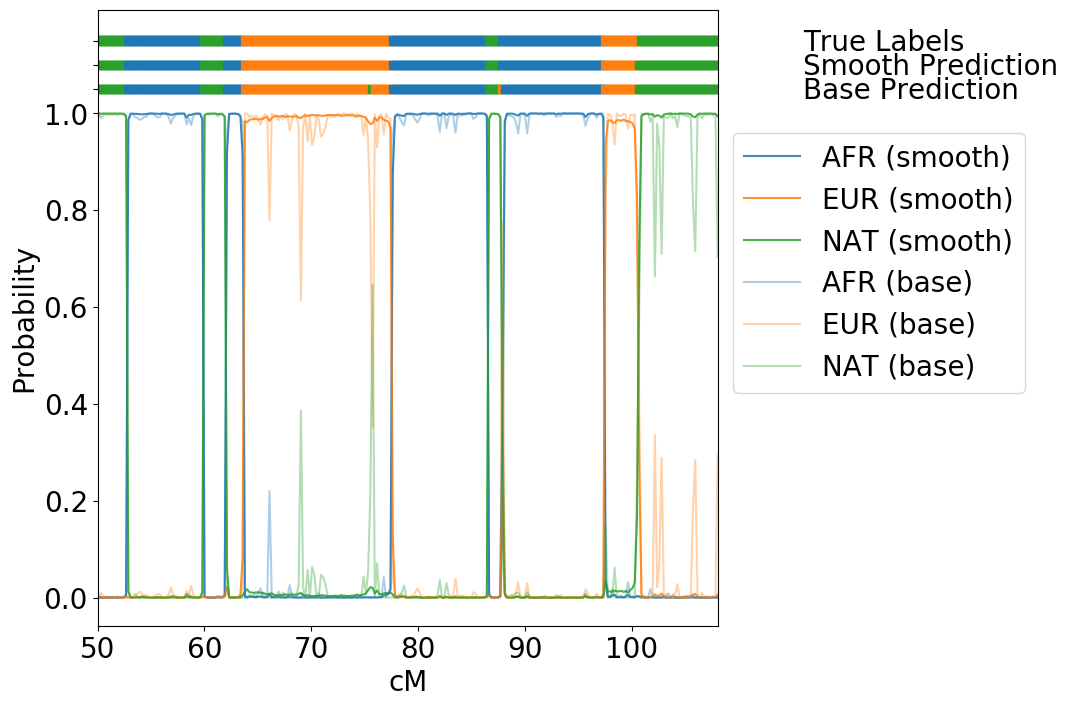

In [75]:
xgmix_plot_2d(base_proba, smoother_proba, y_true=y_v, x=x_ticks, pop_order=pop_order,
              rand_ind=185, xlab="cM", toplabelpad=8, xlim=(50,x_ticks[-1]), figsize=(8,8))

## Calibration

In [579]:
val_probs = model.predict_proba(X_v,rtn_calibrated=False)

Loading model...


/home/wknd37/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [580]:
# calibrate on t1 (biased input but larga set and unseen founders)
model.calibrate = True

# train and apply calibrator
zs = model.predict_proba(X_t1,rtn_calibrated=False).reshape(-1,model.num_anc)
model.calibrator = calibrator_module(zs, y_t1.reshape(-1), model.num_anc, method ='Isotonic')  
model._evaluate_smooth(X_t2,y_t2,X_v,y_v)

# evaluate accuracy
val_acc_cal = model.smooth_acc_val

# evaluate log loss
val_probs_cal = model.predict_proba(X_v)
val_ll_cal = log_loss(y_v.reshape(-1), val_probs_cal.reshape(-1, model.num_anc))

model.calibrate = False

print(val_acc_cal)

Smooth Training Accuracy: 98.11%
Smooth Validation Accuracy: 96.04%
96.04


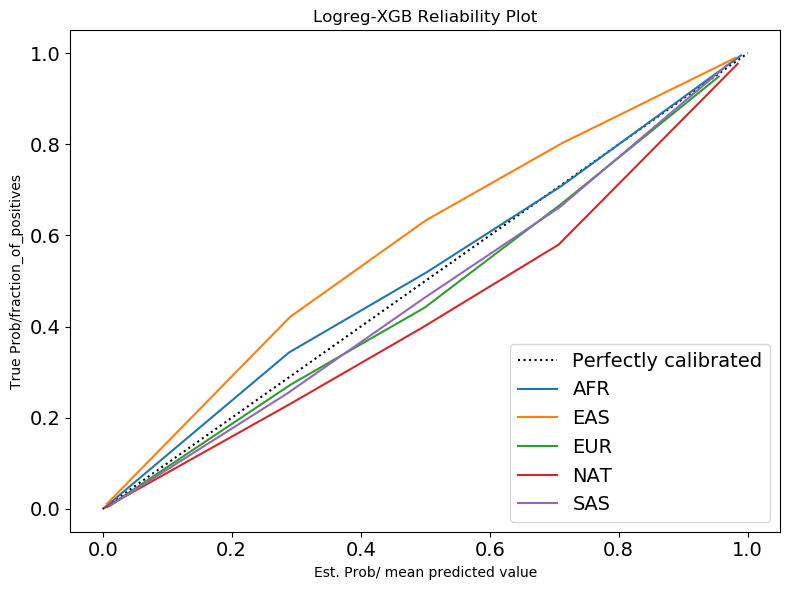

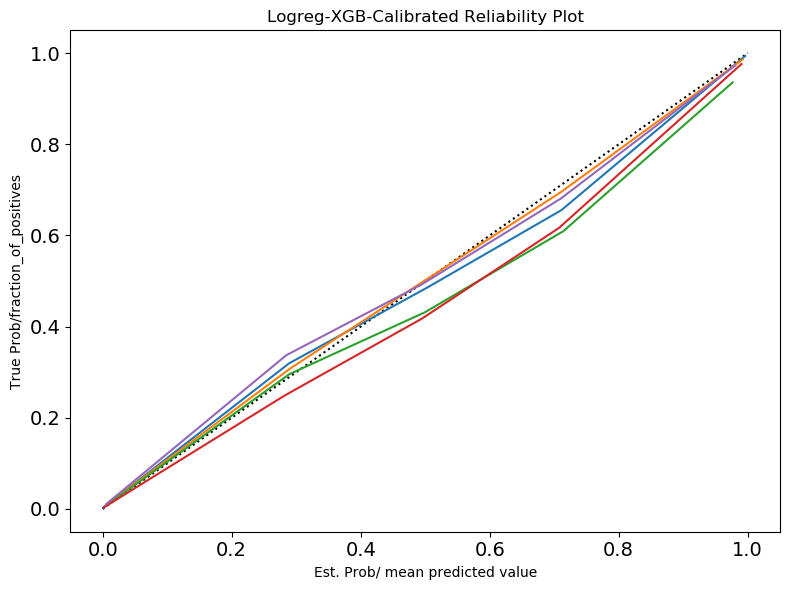

In [589]:
out_XGB = plot_reliability_curve(val_probs,y_v,pop_order,method='Logreg-XGB',bins=5)
out_XGB_cal = plot_reliability_curve(val_probs_cal,y_v,pop_order,method='Logreg-XGB-Calibrated',bins=5,legend=False)

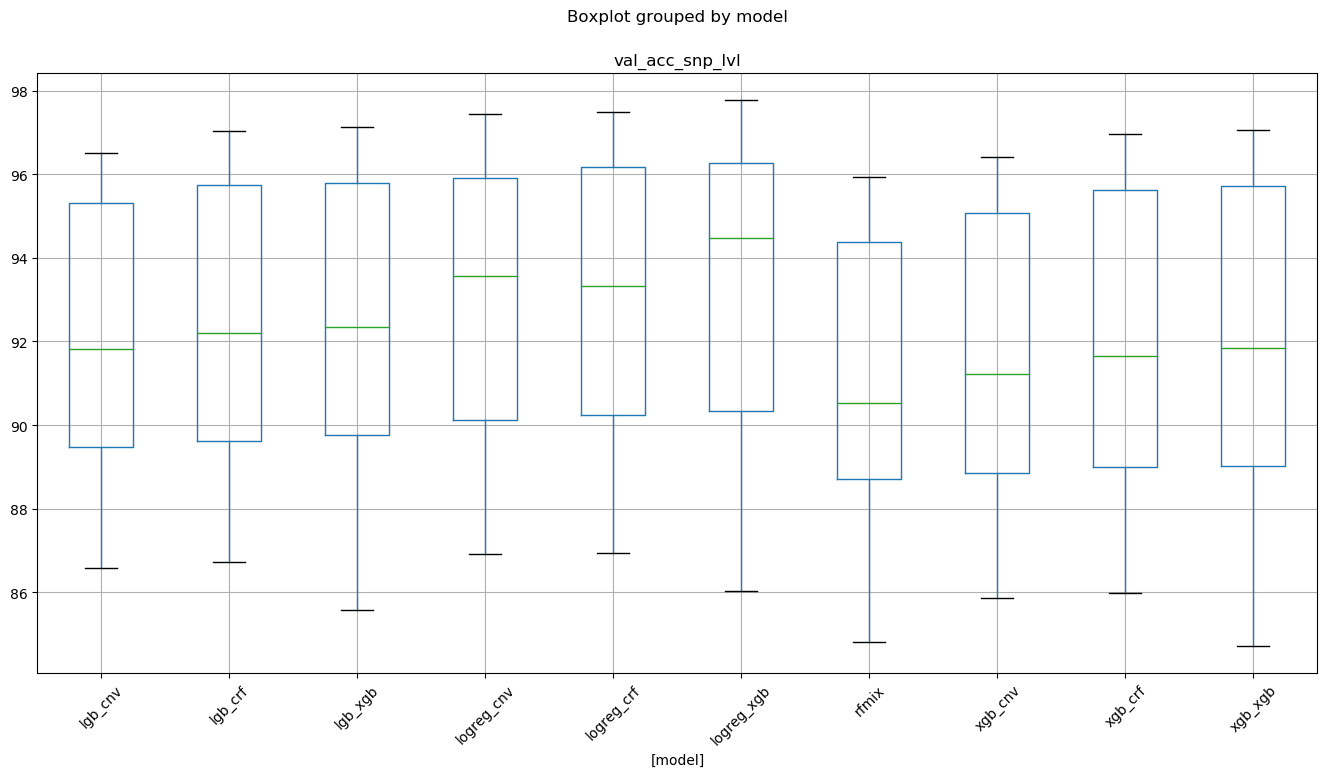

In [200]:
DF.boxplot(column=["val_acc_snp_lvl"], by=["model"], figsize=(16,8), rot="45")
plt.show()

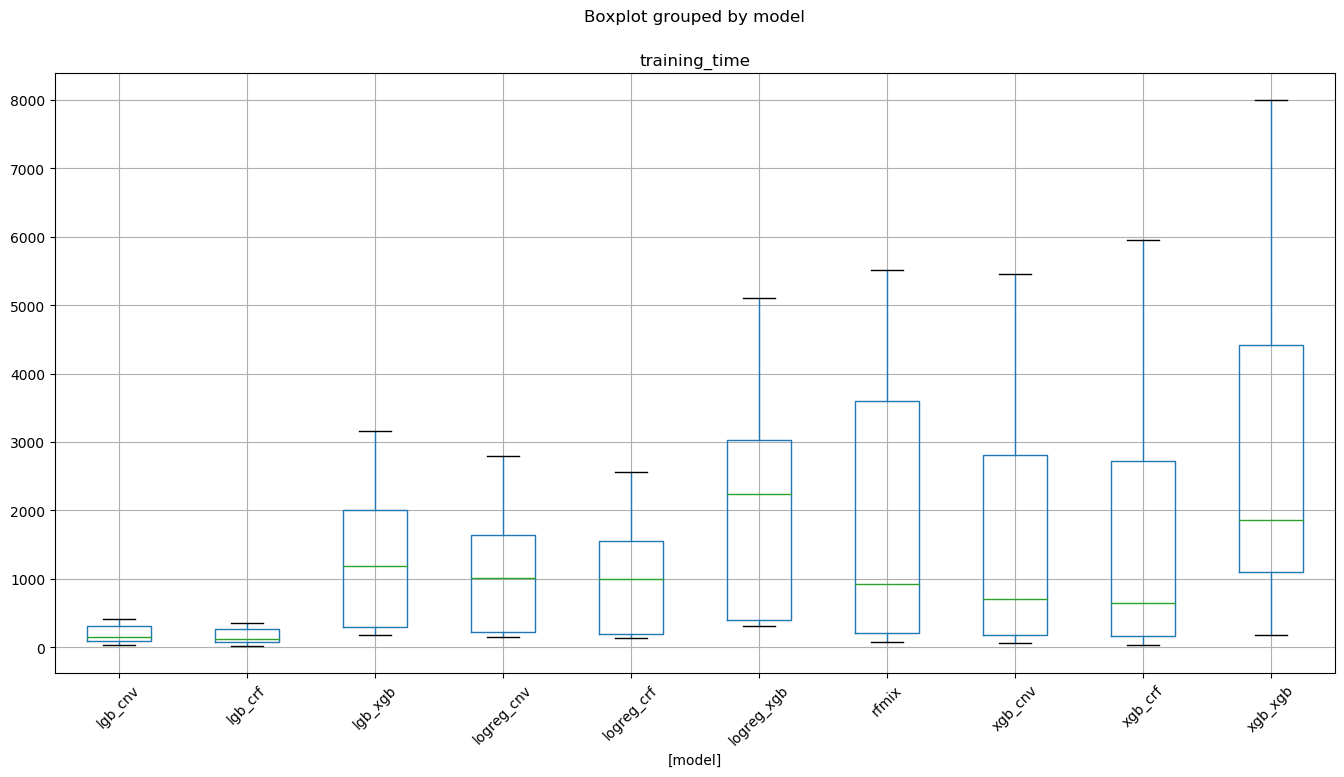

In [36]:
DF.boxplot(column=["training_time"], by=["model"], figsize=(16,8), rot="45")
plt.show()

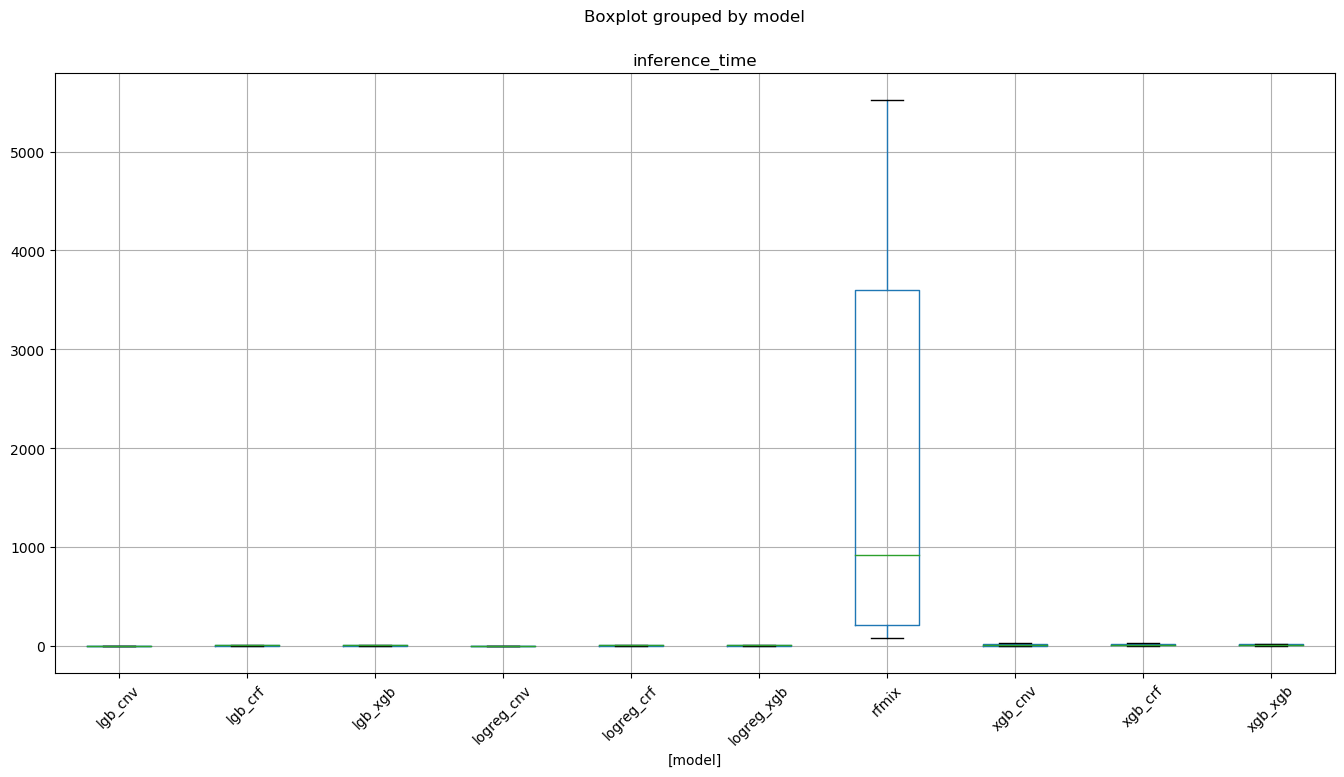

In [35]:
DF.boxplot(column=["inference_time"], by=["model"], figsize=(16,8), rot="45")
plt.show()

## LogReg x XGB performing best

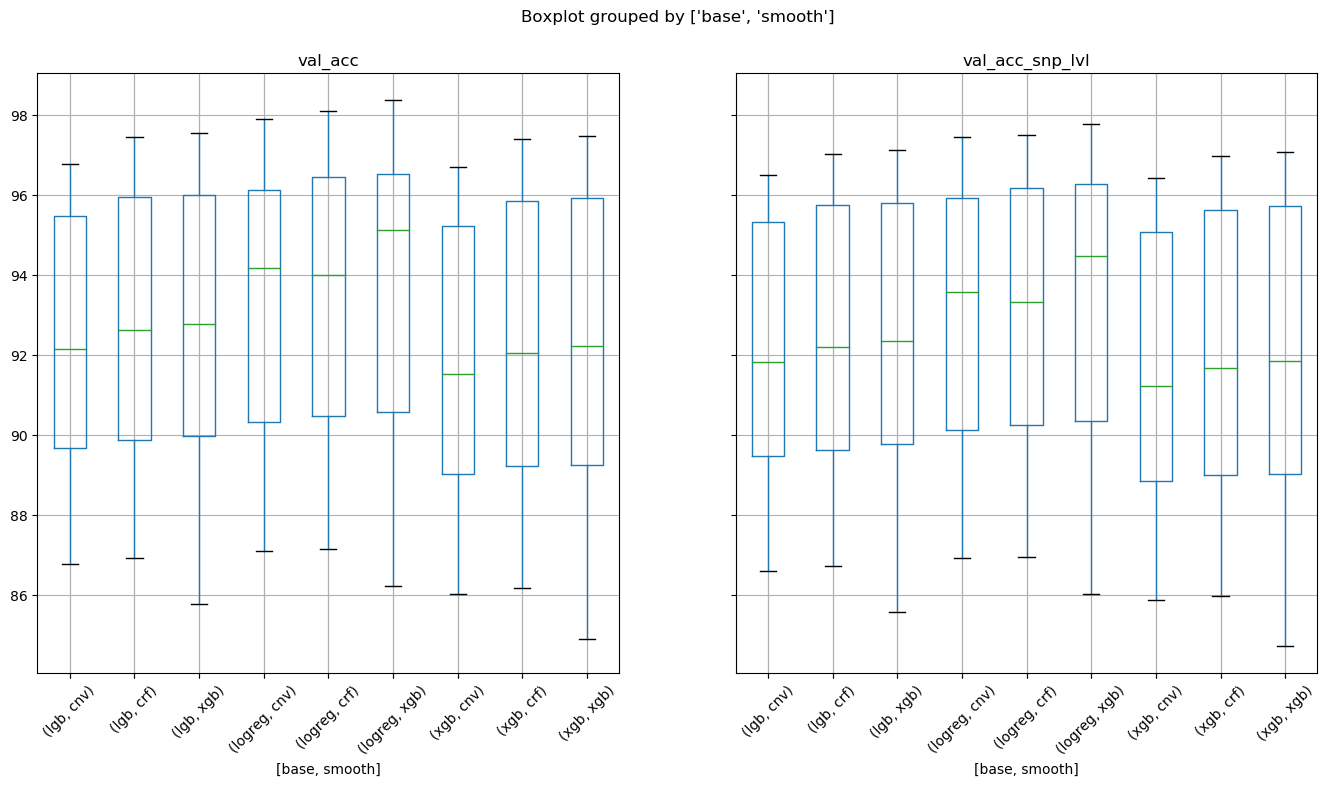

In [56]:
DF_us.boxplot(column=["val_acc", "val_acc_snp_lvl"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

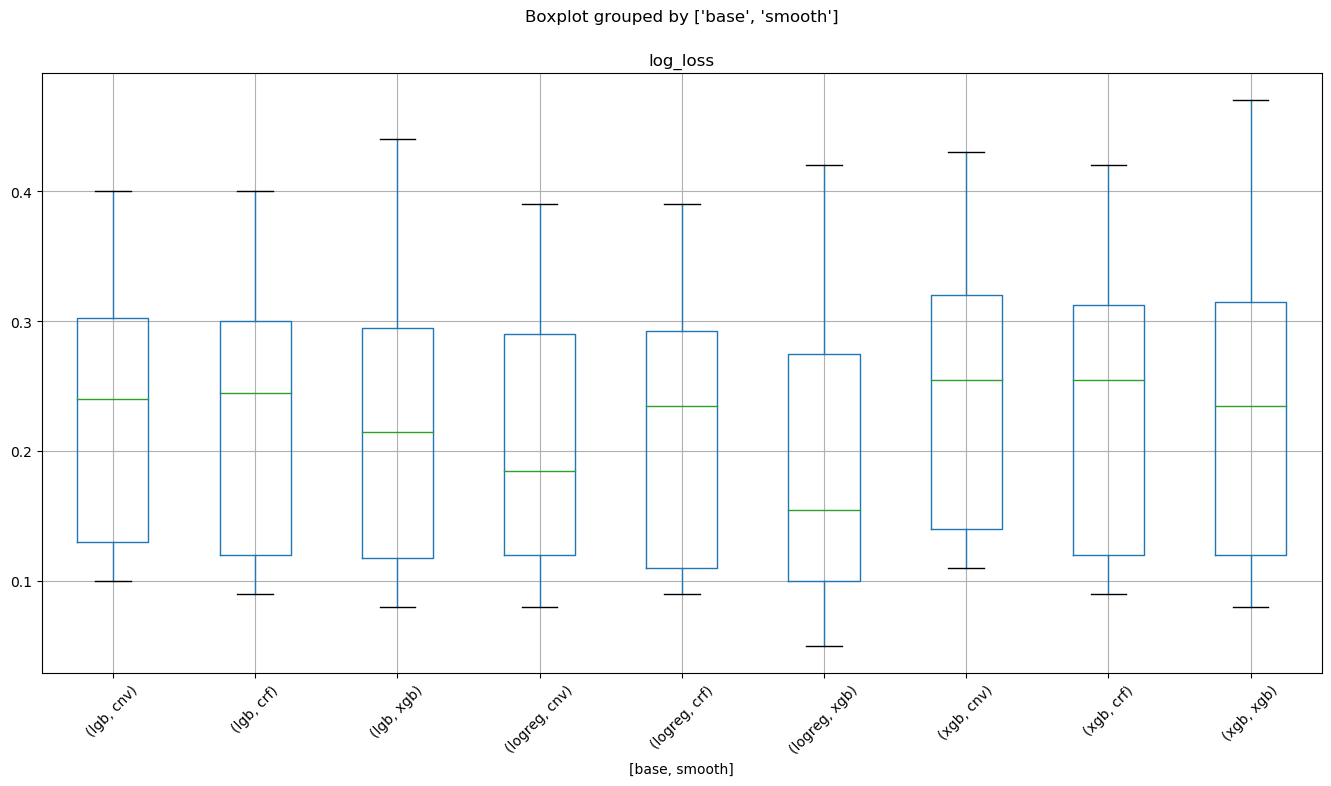

In [57]:
DF_us.boxplot(column=["log_loss"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

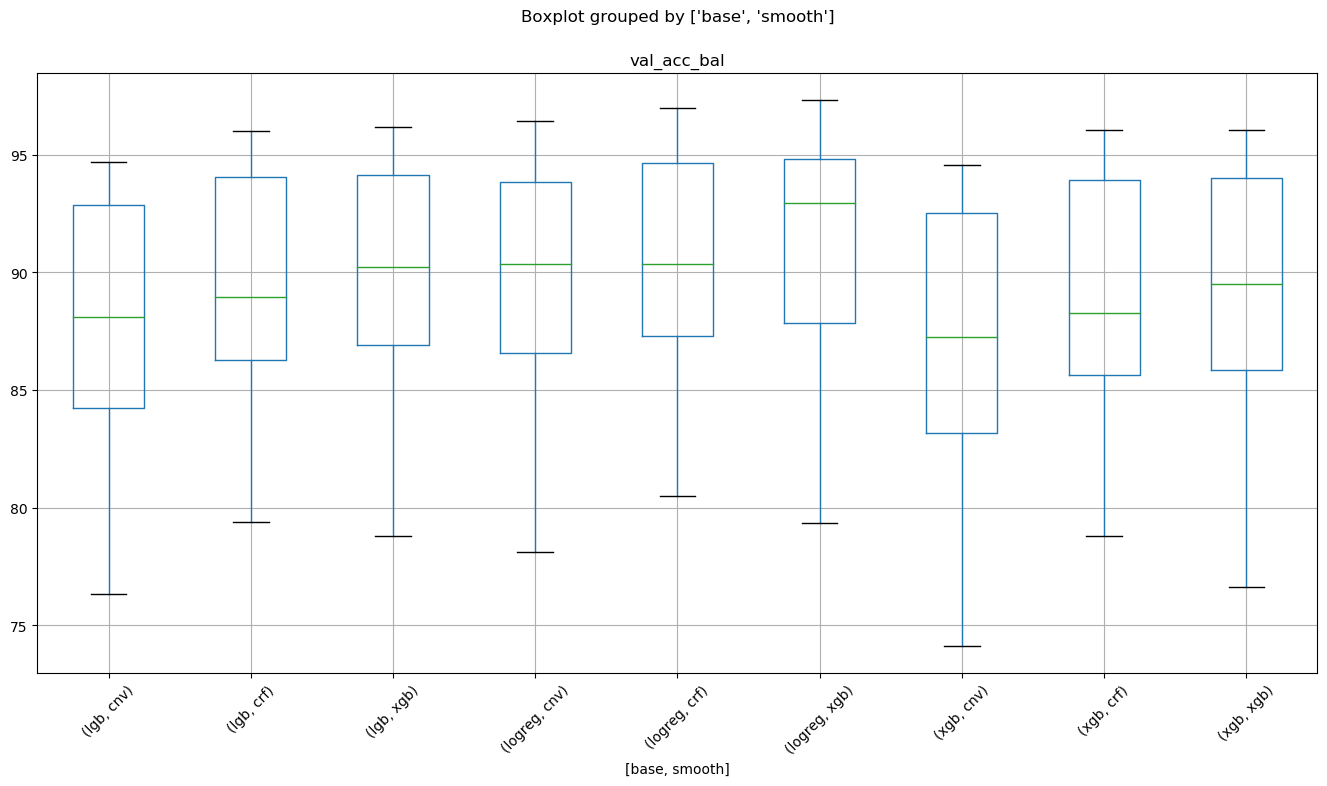

In [58]:
DF_us.boxplot(column=["val_acc_bal"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

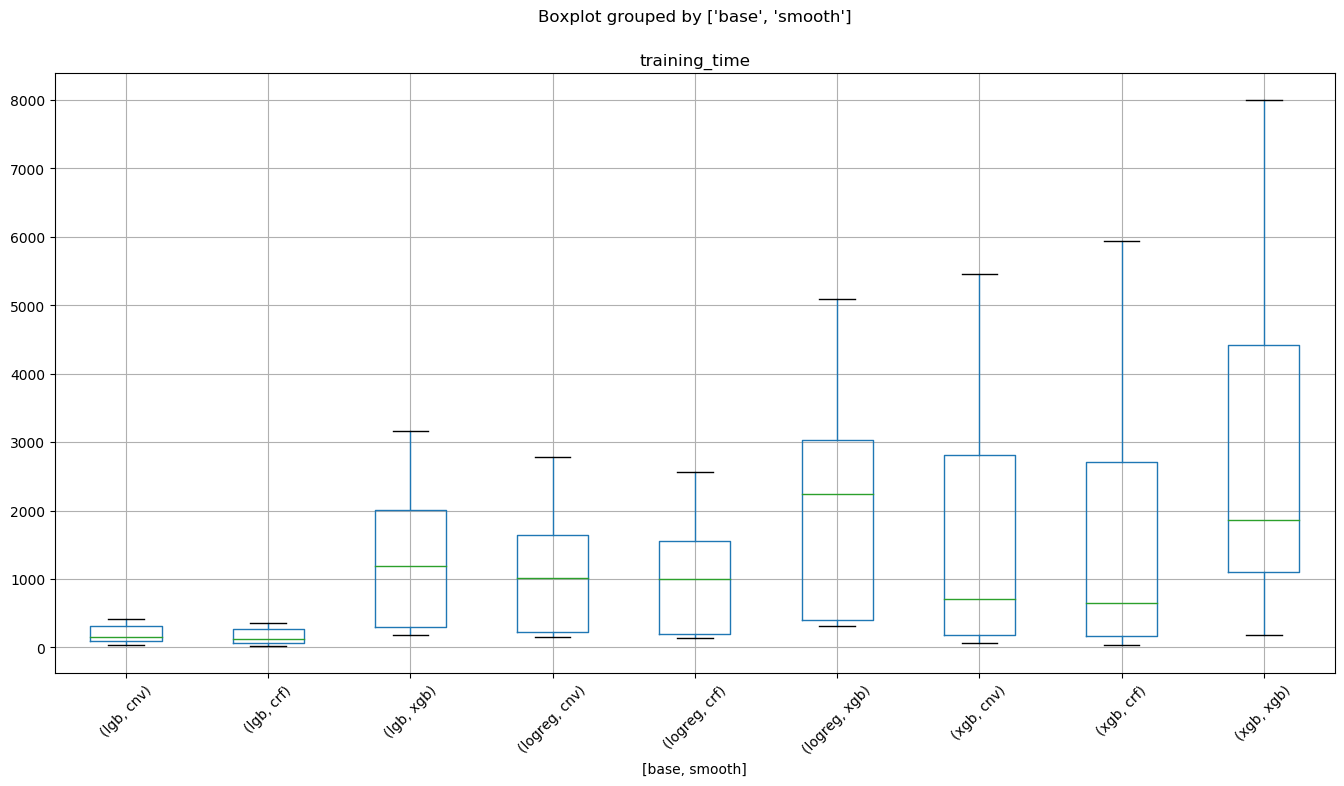

In [14]:
DF_us.boxplot(column=["training_time"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

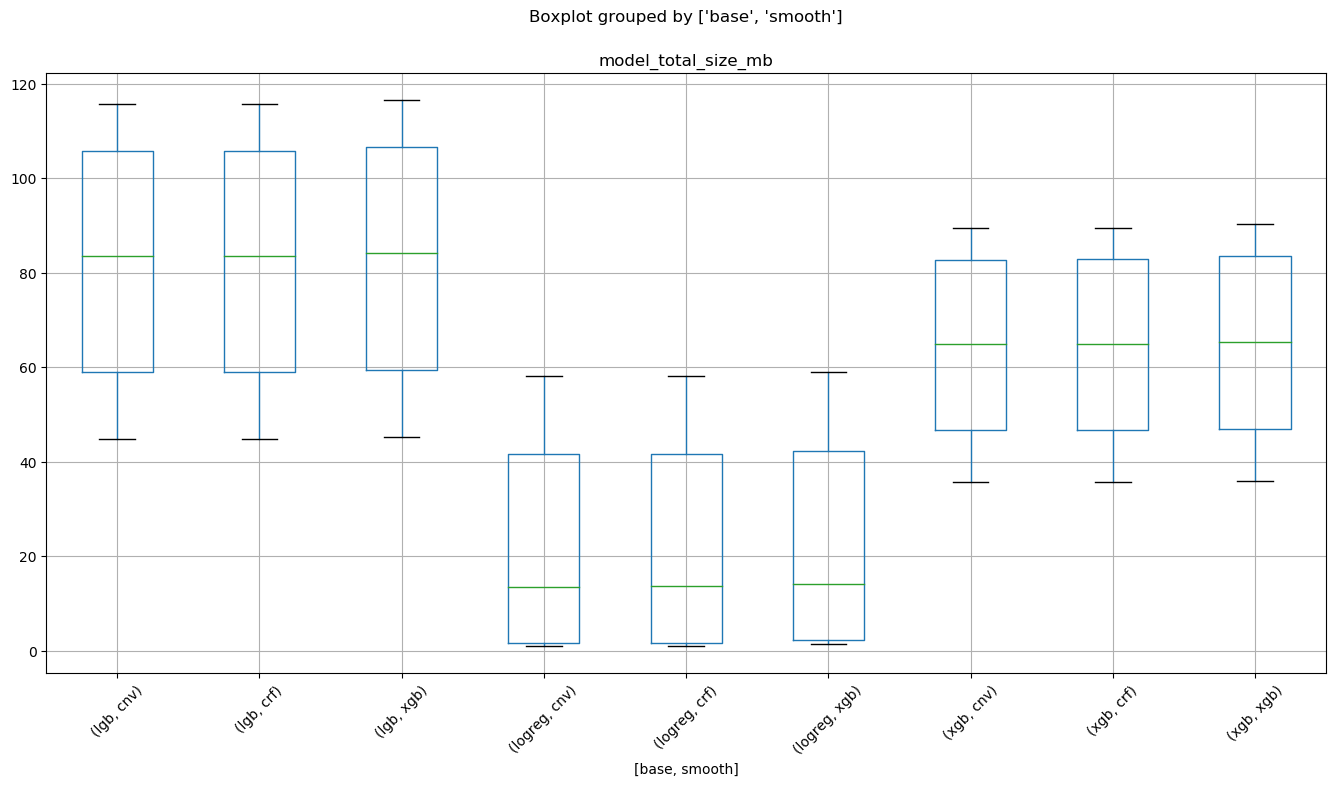

In [15]:
DF_us.boxplot(column=["model_total_size_mb"], by=["base", "smooth"], figsize=(16,8), rot="45")
plt.show()

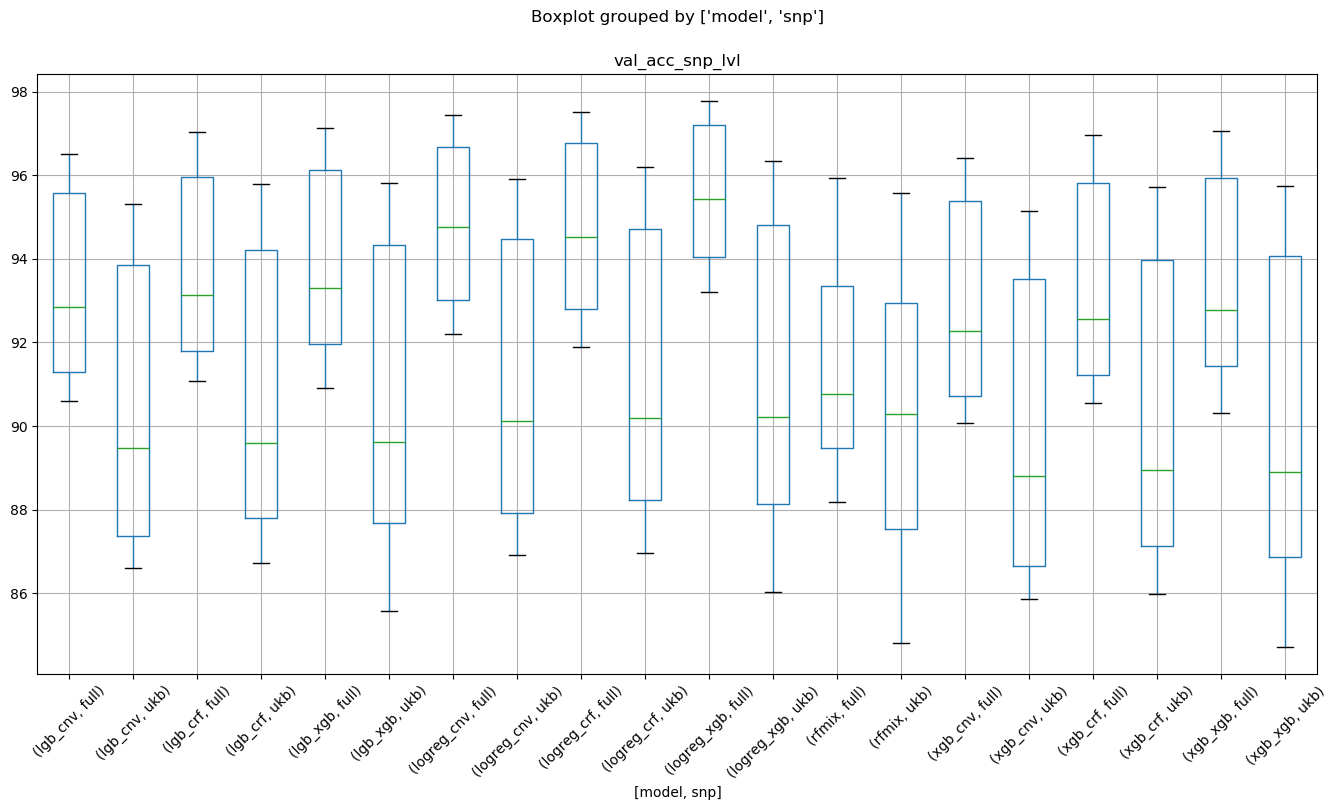

In [62]:
DF.boxplot(column=["val_acc_snp_lvl"], by=["model", "snp"], figsize=(16,8), rot="45")
plt.show()

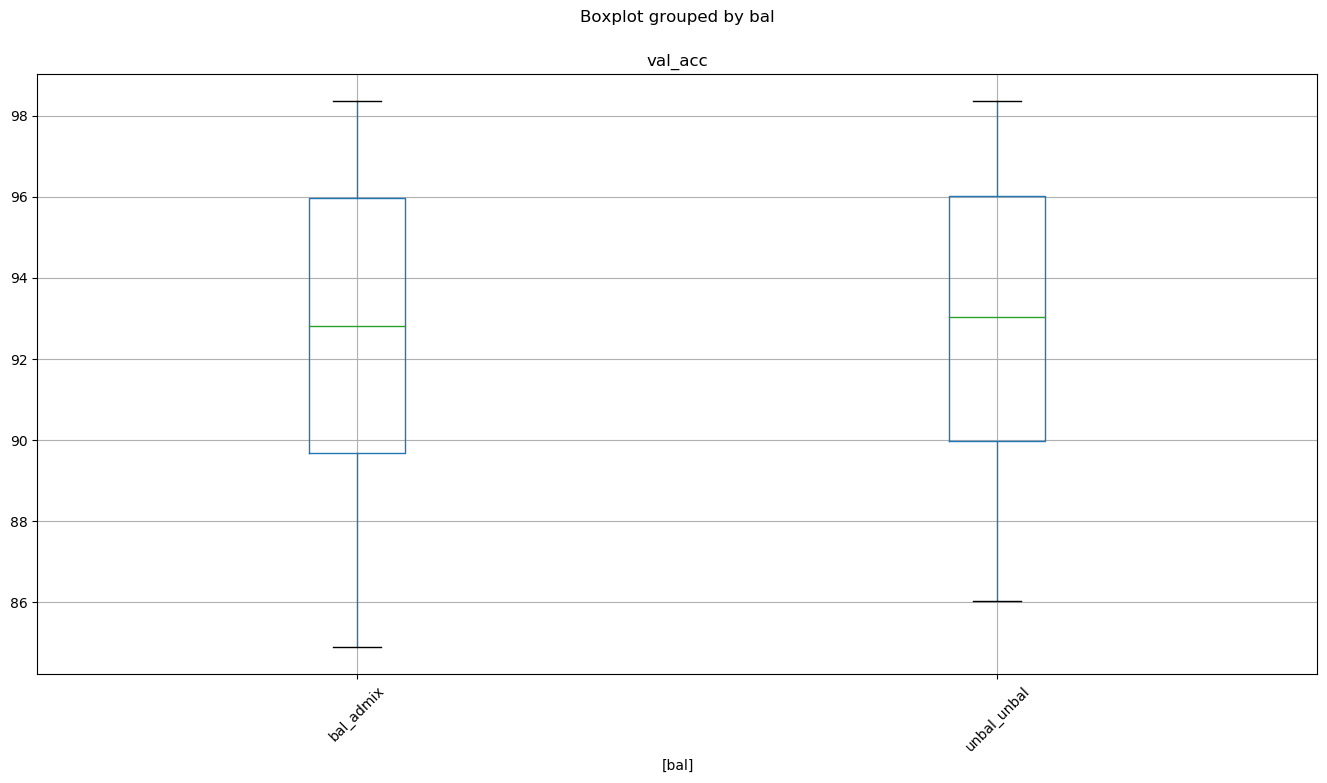

In [63]:
DF_us.boxplot(column=["val_acc"], by=["bal"], figsize=(16,8), rot="45")
plt.show()

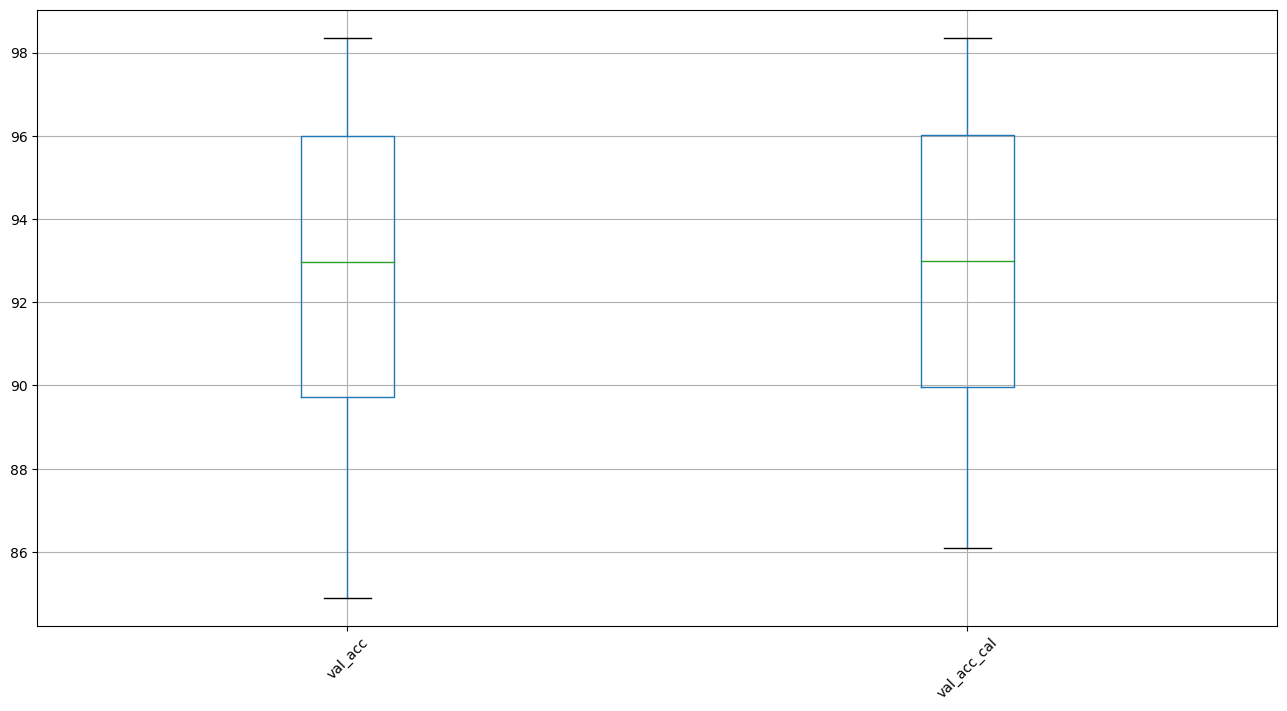

In [64]:
DF_us.boxplot(column=["val_acc", "val_acc_cal"], figsize=(16,8), rot="45")
plt.show()

## Note! acc > 90% for gen 100